# Capstone Project - Pnemonia detection


In [1]:
#Include all the modules we need for this project
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random as rnd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from scipy.stats import zscore
from sklearn import metrics
from sklearn.impute import SimpleImputer
import math
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.naive_bayes import GaussianNB # using Gaussian algorithm from Naive Bayes
import pickle
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
# !pip install tensorflow
import tensorflow as tf
import keras.layers as layers
import keras.models as models
from tensorflow.keras import losses
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, VGG19, VGG16
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon
from tensorflow.keras.layers import AveragePooling2D, Activation, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Input, concatenate, UpSampling2D, Reshape, Conv2DTranspose, Concatenate
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2
import os
# !pip install keras-facenet
# from keras_facenet import FaceNet
from google.colab.patches import cv2_imshow
!pip install pydicom
import pydicom as dicom
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.8 MB/s eta 0:00:00


# Milestone 1

## Step 1: Import the data.

In [2]:
#Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

#when downloading Project data to Mac, the zip got copied as a folder. Nothing further needed to import data.
images_path = "/content/drive/MyDrive/Colab Notebooks/Capstone - Pneumonia/10. Capstone - Pnemonia"

#Setup the csv files into dataframes - need to read only stage_2_train_labels.csv and stage_2_details_class_info.csv
df1A = pd.read_csv(images_path + "/stage_2_train_labels.csv")
display(df1A.head(10))
print("Train_labels shape :", df1A.shape)
print("Train labels: Unique patientIds we have: ", df1A['patientId'].nunique())
tmp = df1A[df1A.duplicated(['patientId', 'x', 'y', 'width', 'height', 'Target'])]
print("Train labels: pure duplicates (all rows same) : ", tmp.shape[0])
#there are multiple entries for the same patientId with different image coordinates. these are diff. images possibly, so keep them
#eg. df1A[df1A['patientId'] == '00704310-78a8-4b38-8475-49f4573b2dbb'] there are two different entries.

df1B = pd.read_csv(images_path + "/stage_2_detailed_class_info.csv")
display(df1B.head(10))
print("Detailed_class_info shape ", df1B.shape)
print("Detailed_class_info: Unique patientIds we have: ", df1B['patientId'].nunique())
tmp = df1B[df1B.duplicated(['patientId', 'class'])]
print("Detailed_class_info: pure duplicates (all rows same) : ", tmp.shape[0])
#here though there seem to be duplicates, but they are not. When matched to df1A, they will be separate entries
#eg. df1B[df1B['patientId'] == '00704310-78a8-4b38-8475-49f4573b2dbb']

#do below to merge - but this is punching holes in the index sequence
# df1 = df1A.merge(df1B, on='patientId')
# df1 = df1.drop_duplicates()
# display(df1.head(10))
# print("merged DF shape ", df1.shape)

if (df1A['patientId'] == df1B['patientId']).sum() == df1A.shape[0]:
  print("patientId are same in both dataframes.")
  #Include the class column into the first dataframe
  df1A['class'] = df1B['class']

print("Merged dataframe")
display(df1A.head(10))
df1A.shape

Mounted at /content/drive


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

Train_labels shape : (30227, 6)
Train labels: Unique patientIds we have:  26684
Train labels: pure duplicates (all rows same) :  0


patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

Detailed_class_info shape  (30227, 2)
Detailed_class_info: Unique patientIds we have:  26684
Detailed_class_info: pure duplicates (all rows same) :  3543
patientId are same in both dataframes.
Merged dataframe


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0   
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0   
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  
5                  Lung Opacity  
6  No Lung Opacity / Not Normal  
7  No Lung Opacity / Not Normal  
8                  Lung Opacity  
9                  Lung Opacity

(30227, 7)

## Step 2: Map training and testing images to its classes.

In [3]:
#Training data mapping

#Important data from mentor session - add Age, Sex into the input feature set
# def pullSexAge(rowData):
#     dcm_file = images_path+'/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
#     dcm_data = dicom.dcmread(dcm_file)
#     return dcm_data.PatientSex,dcm_data.PatientAge

# df1A['sex'], df1A['age'] = zip(*df1A.apply(pullSexAge, axis=1)) #we are not using this really, but good for visualization
# display(df1A.head(5))

#below code executed once and pickle'd on drive to avoid high execution time parsing all the image files
# X = []
# Y = []
# fn = []
# cnt = 0
# dir_name = images_path + "/stage_2_train_images"
# for file_train in os.listdir(dir_name):
#   cnt = cnt + 1
#   # print("File count ", cnt)
#   f = os.path.join(dir_name, file_train)
#   if os.path.isfile(f):
#     f_dash = os.path.splitext(file_train)[0]
#     if(df1A[df1A['patientId'] == f_dash].shape[0] != 0):
#       dicom_file = dicom.dcmread(f)
#       #put the image into the list X
#       X.append(cv2.resize(dicom_file.pixel_array, (256,256)))
#       #put the target variable in the list Y
#       Y.append(df1A[df1A['patientId'] == f_dash].iloc[0][6])
#       fn.append(file_train)
#     else:
#       print("Ignoring file ", f_dash)
#   # if cnt == 10:
#   #   break;
# X = np.array(X)
# Y = np.array(Y)
# # review the shape of the input and target arrays we have put together
# display(X.shape)
# display(Y.shape)
# with open(images_path + 'outfile_X_Train', 'wb') as fp:
#     pickle.dump(X, fp)
# with open(images_path + 'outfile_Y_Train', 'wb') as fp:
#     pickle.dump(Y, fp)
# with open(images_path + 'outfile_fn_Train', 'wb') as fp:
#     pickle.dump(fn, fp)

with open (images_path + 'outfile_X_Train', 'rb') as fp:
    X = pickle.load(fp)
with open (images_path + 'outfile_Y_Train', 'rb') as fp:
    Y = pickle.load(fp)
with open (images_path + 'outfile_fn_Train', 'rb') as fp:
    fn = pickle.load(fp)

X = np.expand_dims(X, axis=-1) #need to do this for CNN input layer
#target variable needs label encoding
le = preprocessing.LabelEncoder()
Y_le = le.fit_transform(Y) #the 'Normal' series values map to the index appended in y_pred_final
display(list(le.classes_))

Y_dash = pd.DataFrame({'target': Y_le}, columns=['target'])
# Y_dash.loc[Y_dash['target'] == 'No Lung Opacity / Not Normal'] = 'Normal' #do this to get to binary classification
Y_dash = pd.get_dummies(Y_dash['target'])
print("Train img shape ", X.shape)
print("Train target shape ", Y_dash.shape)
display(Y_dash.head())
display(Y_dash.value_counts())

#Train images are now mapped to the classes - X and Y_dash.

['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal']

Train img shape  (26684, 256, 256, 1)
Train target shape  (26684, 3)


0  1  2
0  0  0  1
1  0  1  0
2  0  0  1
3  0  0  1
4  0  0  1

0  1  2
0  1  0    11821
   0  1     8851
1  0  0     6012
dtype: int64

In [4]:
#Test images - no labels provided. Need to assume they are for placing bounding box (milestone 2)
df2 = pd.read_csv(images_path + "/stage_2_sample_submission.csv")
display(df2.head(10))
display(df2.shape)

#below code executed only once and pickle'd, to avoid high execution times
# X_t = []
# Y_t = []
# fn_t = []
# cnt = 0
# unknown = 0
# dir_name = images_path + "/stage_2_test_images"
# for file_train in os.listdir(dir_name):
#   # print("File count ", cnt)
#   f = os.path.join(dir_name, file_train)
#   if os.path.isfile(f):
#     cnt = cnt + 1
#     f_dash = os.path.splitext(file_train)[0]
#     dicom_file = dicom.dcmread(f)
#     #put the image into the list X
#     X_t.append(cv2.resize(dicom_file.pixel_array, (256,256)))
#     fn_t.append(file_train)
#     if(df2[df2['patientId'] == f_dash].shape[0] != 0):
#       #put the target variable in the list Y as Pnemonia
#       Y_t.append('Lung Opacity')      
#     else:
#       #we dont know anything about this one.
#       Y_t.append('Unknown')
#       print("Count ", cnt, ": Not in csv list:  ", f_dash, ". Putting as 'unknown'")
#       unknown = unknown+1
#   # if cnt == 10:
#   #   break;
# print('Unknown images (not in sample_sbumission csv) : ', unknown)
# X_t = np.array(X_t)
# Y_t = np.array(Y_t)
# with open(images_path + 'outfile_X_Test', 'wb') as fp:
#     pickle.dump(X_t, fp)
# with open(images_path + 'outfile_Y_Test', 'wb') as fp:
#     pickle.dump(Y_t, fp)
# with open(images_path + 'outfile_fn_Test', 'wb') as fp:
#     pickle.dump(fn_t, fp)

with open (images_path + 'outfile_X_Test', 'rb') as fp:
    X_t = pickle.load(fp)
with open (images_path + 'outfile_Y_Test', 'rb') as fp:
    Y_t = pickle.load(fp)
with open (images_path + 'outfile_fn_Test', 'rb') as fp:
    fn_t = pickle.load(fp)

X_t = np.expand_dims(X_t, axis=-1)
Y_dash_t = pd.DataFrame({'target': Y_t}, columns=['target'])
Y_dash_t = pd.get_dummies(Y_dash_t['target']) #this is not correct, should be ignored
fn_dash_t = pd.DataFrame({'filename': fn_t}, columns=['filename'])
print("Test img shape ", X_t.shape)
print("Test target shape ", Y_dash_t.shape)
display(fn_dash_t.head())

#to be double-sure, just check if test images are duplicated/listed in training folder image list.
ext_cnt = 0
for x in fn_dash_t['filename']:
  if x in fn: #checking if the test images are in the training set image list
    ext_cnt = ext_cnt + 1
    print (x, " Exists")
print("No. of test image filenames that are available in training data folder ", ext_cnt)

#Test data - Images mapped into X_t, but labels unavailable for classification.
#we will need to take test images from the training set itself.

patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100
5  0015597f-2d69-4bc7-b642-5b5e01534676  0.5 0 0 100 100
6  001b0c51-c7b3-45c1-9c17-fa7594cab96e  0.5 0 0 100 100
7  0022bb50-bf6c-4185-843e-403a9cc1ea80  0.5 0 0 100 100
8  00271e8e-aea8-4f0a-8a34-3025831f1079  0.5 0 0 100 100
9  0028450f-5b8e-4695-9416-8340b6f686b0  0.5 0 0 100 100

(3000, 2)

Test img shape  (3026, 256, 256, 1)
Test target shape  (3026, 2)


filename
0  257f3de7-2f8f-4dba-a0e7-37fc3e6cc018.dcm
1  252437ed-a4e2-4743-995c-65a4bb133996.dcm
2  268116a6-2304-4316-b5b3-3073fc5467b1.dcm
3  264607e7-a410-4519-b0df-6e5db64c373e.dcm
4  2664366f-4f04-49e1-ab20-19b9173f23bc.dcm

No. of test image filenames that are available in training data folder  0


## Step 3: Map training and testing images to its annotations.

In [ ]:
#Test annotations are unclear - all images have same bounding box.. and all have pnemonia?

#train data, already has the annotations mapped
#split the data to test and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_dash, test_size=0.2, random_state=42)
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_train_rgb = np.squeeze(X_train_rgb)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, -1)
X_test_rgb = np.squeeze(X_test_rgb)
print(X_train_rgb.shape)
print(X_test_rgb.shape)

(21347, 256, 256, 3)
(5337, 256, 256, 3)


## Step 4: Preprocessing and Visualisation of different classes

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

Total No of Patients in Class Info 26684
Total distinct classes:  ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']
Duplicate entries (with more than 1 BB)  3543

Updated data samples:


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

 
Count total NaN at each column in the dataset : 

 patientId    0
x            0
y            0
width        0
height       0
Target       0
class        0
dtype: int64
Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


None

Dataframe describe (numeric data): 



x             y         width        height        Target
count  30227.000000  30227.000000  30227.000000  30227.000000  30227.000000
mean     124.561683    115.960962     69.060575    104.084825      0.316108
std      216.326397    190.012883    106.910496    176.932152      0.464963
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%      193.000000    231.000000    169.000000    188.000000      1.000000
max      835.000000    881.000000    528.000000    942.000000      1.000000

Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


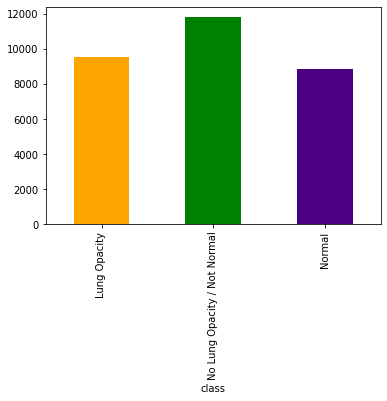

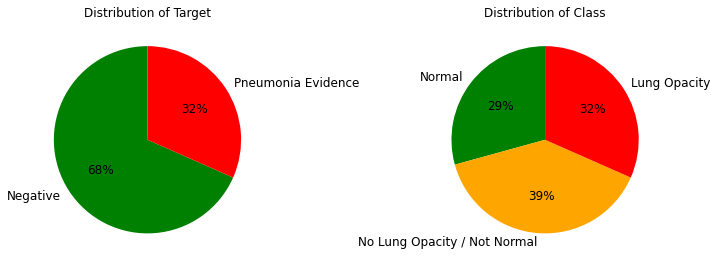

In [ ]:
#preprocessing
# df1A['age'] = df1A.age.astype(int)
#image size reduced to 256x256 already during Step 1
display(df1A.head())
display(df1B.head())
print('Total No of Patients in Class Info', df1B['patientId'].value_counts().shape[0])
print('Total distinct classes: ', df1B['class'].unique())
##Identify duplicates records in the data
dupli = df1B['patientId'].duplicated()
print("Duplicate entries (with more than 1 BB) ", sum(dupli))
df1B.groupby('class').size().plot.bar(5, 10, color=['Orange', 'green', 'Indigo'])
df1A['x'] = df1A['x'].replace(np.nan, 0)
df1A['y'] = df1A['y'].replace(np.nan, 0)
df1A['width'] = df1A['width'].replace(np.nan, 0)
df1A['height'] = df1A['height'].replace(np.nan, 0)
print("\nUpdated data samples:")
display(df1A.head())
print(" \nCount total NaN at each column in the dataset : \n\n", 
      df1A.isnull().sum())
print("Dataframe Info: \n")
display(df1A.info())
print("Dataframe describe (numeric data): \n")
display(df1A.describe())

print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (df1A['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['green', 'red'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (df1B['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['green', 'orange', 'red'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()



Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 8)
Patient Id:  00436515-870c-4b36-a041-de91049b9ab4

Bounding Box Coordinates, X:  264.0

Bounding Box Coordinates, Y:  152.0

Bounding Box Coordinates, Width:  213.0

Bounding Box Coordinates, Height:  379.0
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implem

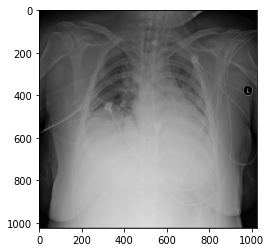

In [ ]:
box_patient_df = df1A.groupby('patientId').size().reset_index(name='boxes')
box_patient_df.groupby('boxes').size().reset_index(name='patients')

print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(df1B.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class_df = pd.concat([df1A, df1B['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class_df.shape))

def checkXray(i, dirName):
    patientId = train_class_df['patientId'][i]
    print("Patient Id: ", patientId)
    fileName = dirName + "/" + patientId
    print("\nBounding Box Coordinates, X: ", train_class_df['x'][i])
    print("\nBounding Box Coordinates, Y: ", train_class_df['y'][i])
    print("\nBounding Box Coordinates, Width: ", train_class_df['width'][i])
    print("\nBounding Box Coordinates, Height: ", train_class_df['height'][i])
    
    patient_file = '%s.dcm' % fileName
    patient_data = dicom.read_file(patient_file)
    print(patient_data)
    
    plt.imshow(patient_data.pixel_array,cmap=plt.cm.gist_gray)

TRAIN_IMG_DCM=images_path + '/stage_2_train_images'
# checkXray(3, TRAIN_IMG_DCM)
checkXray(4, TRAIN_IMG_DCM)

#visualizations


In [ ]:
# Helper function to get additional features from dicom images
from glob import glob
from tqdm.notebook import tqdm_notebook

def get_tags(data, path):
    images = os.listdir(path)
    for i, name in tqdm_notebook(enumerate(images)):
        # print('get_tags: ', i)
        img_path = os.path.join(path, name)
        img_data = dicom.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality

# get_tags(train_class_df, TRAIN_IMG_DCM)
# train_class_df.to_pickle(images_path + '/train_feature_engineered.pkl')
train_class_df = pd.read_pickle(images_path + '/../train_feature_engineered.pkl')

print('Read the training images file names and path'); print('--'*40)
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMG_DCM, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
# assert images.shape[0] == len(list(set(train_class_df['patientId']))), 'Number of training images should be equal to the unique patientIds we have'
print('Merge path from the `images` dataframe with `train_class` dataframe'); print('--'*40)
train_class_df = train_class_df.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class_df.shape))

train_class_df.head()

display(train_class_df.shape)
print('As expected unique in `BodyPartExamined` is: {}'.format(train_class_df['BodyPartExamined'].unique()[0]))
print('Unique in `Modality` is: {}'.format(train_class_df['Modality'].unique()[0])); print('--'*40)



Read the training images file names and path
--------------------------------------------------------------------------------
Number of images in the training folder: 26811
Columns in the training images dataframe: ['path', 'patientId']
Merge path from the `images` dataframe with `train_class` dataframe
--------------------------------------------------------------------------------
Shape of the `train_class` dataframe after merge: (30227, 15)


(30227, 15)

As expected unique in `BodyPartExamined` is: CHEST
Unique in `Modality` is: CR
--------------------------------------------------------------------------------


Overall the distribution is almost equal for `ViewPosition` but where there's a Pneumonia Evidence, `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior
--------------------------------------------------------------------------------
Plot x and y centers of bounding boxes
--------------------------------------------------------------------------------


<ipython-input-48-3894e3a9efb4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
<ipython-input-48-3894e3a9efb4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2


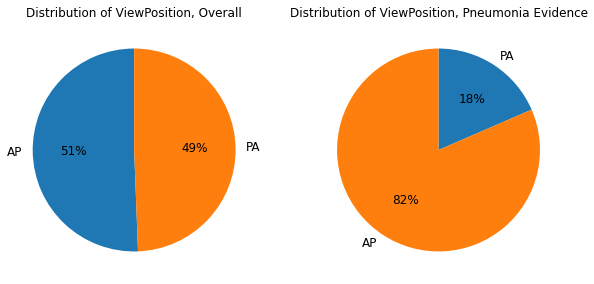

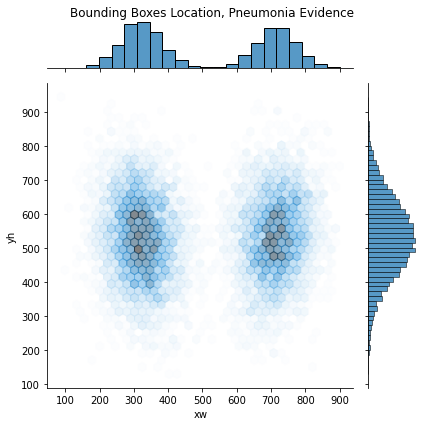

Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


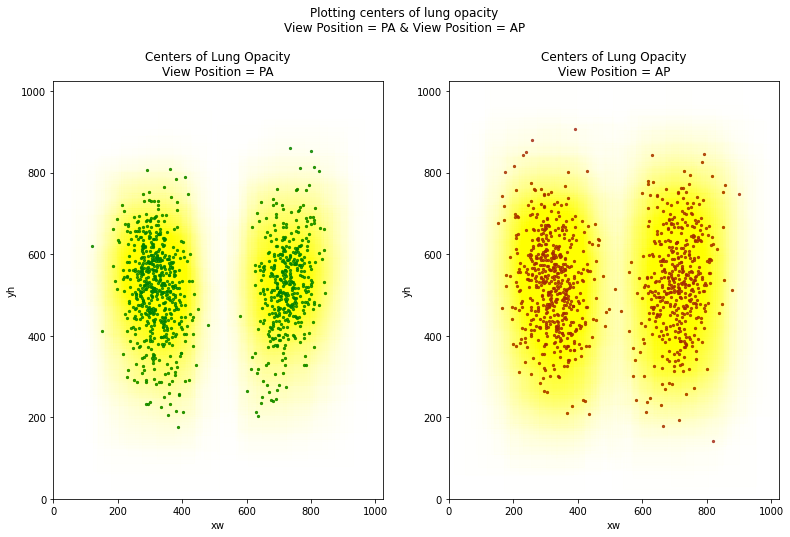

Checking outliers in `PatientAge
--------------------------------------------------------------------------------
Minimum `PatientAge` in the training dataset: 1.0
Maximum `PatientAge` in the training dataset: 100.0
75th Percentile of `PatientAge` in the training dataset: 59.0
`PatientAge` in upper whisker for box plot: 84.0

Using pd.clip to set upper threshold of 100 for age and remove outliers
--------------------------------------------------------------------------------
Get the distribution of `PatientAge` overall and where Target = 1
--------------------------------------------------------------------------------
Creating Age Binning field --------------------------------------------------------------------------------
Value counts of the age bin field created
--------------------------------------------------------------------------------


Counts of Age Bins, Overall  Counts of Age Bins, Target=1
<=26                          3972                          1478
<=50                         12157                          3917
<=75                         13318                          3895
<=100                          780                           265


Exploring the bounding boxes centers for `AgeBins` for random sample = 200


<ipython-input-48-3894e3a9efb4>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
<ipython-input-48-3894e3a9efb4>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


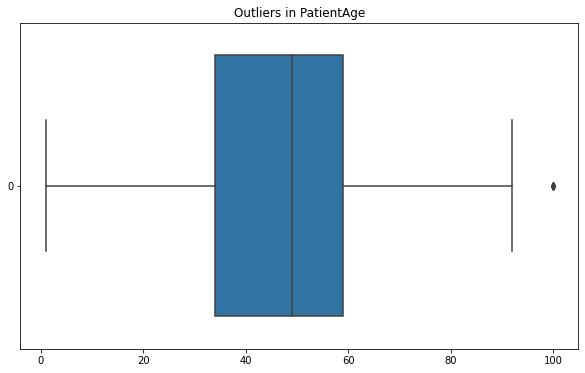

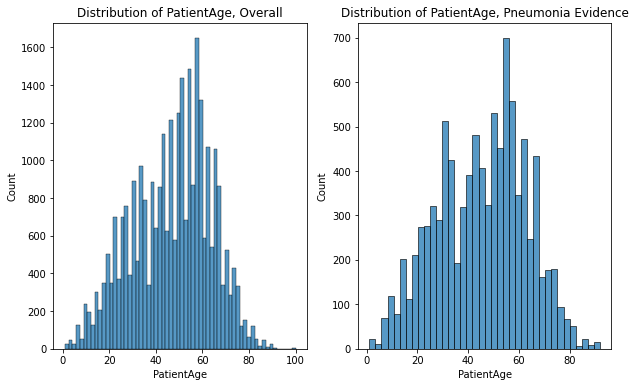

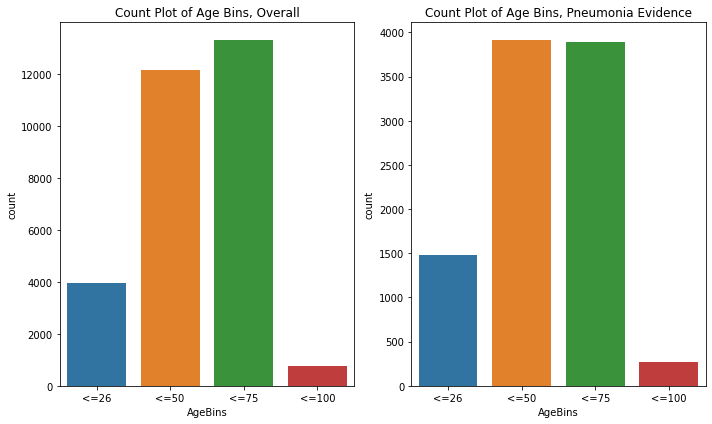

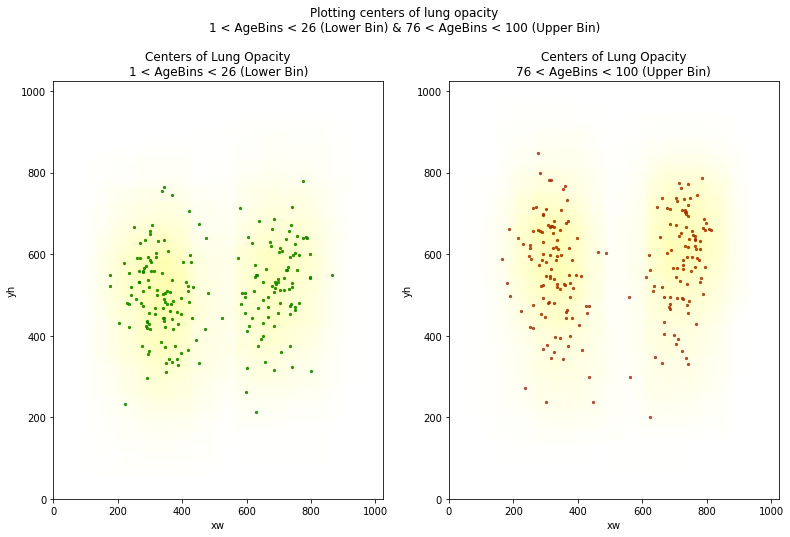

Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender
--------------------------------------------------------------------------------


% Gender, Overall  % Gender, Target=1
F               0.43                0.42
M               0.57                0.58

Exploring the bounding boxes centers for `PatientSex` for random sample = 1000


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


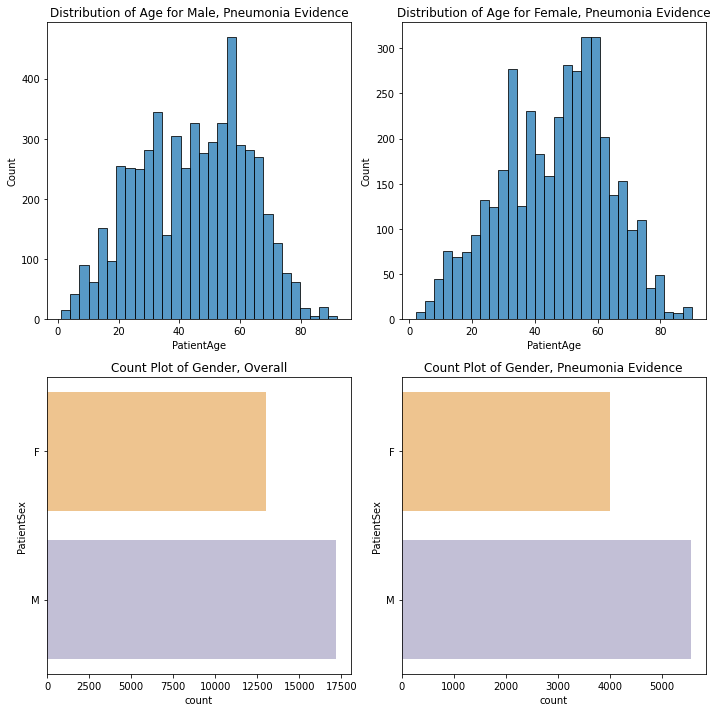

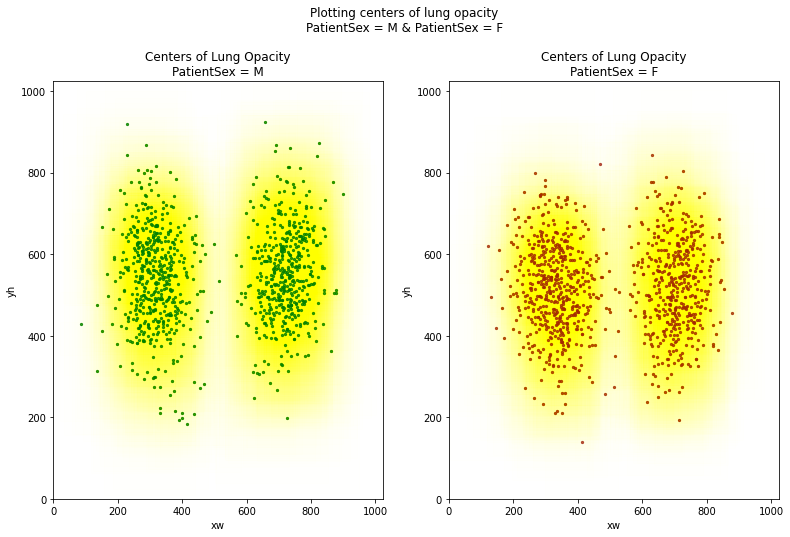

(30227, 12)

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class                         class  \
0  No Lung Opacity / Not Normal  No Lung Opacity / Not Normal   
1  No Lung Opacity / Not Normal  No Lung Opacity / Not Normal   
2  No Lung Opacity / Not Normal  No Lung Opacity / Not Normal   
3                        Normal                        Normal   
4                  Lung Opacity                  Lung Opacity   

                                                path PatientSex  PatientAge  \
0  /content/drive/MyDrive/Capstone-Pneumonia/10.C...          F        51.0   
1  /content/drive/MyDrive/Capstone-Pneumonia/10.C...          F        48.0   
2  /content/drive/MyDrive/Capstone-Pneumonia/10.C...          M        19.0   
3  /content/drive/MyDrive/Capstone-Pneumonia/10.C...          M        28.0   
4  /content/drive/MyDrive/Capstone-Pneumonia/10.C...          F        32.0   

  ViewPosition  
0           PA  
1           PA  
2           AP  
3           PA  
4           AP

Checking sample for different classes


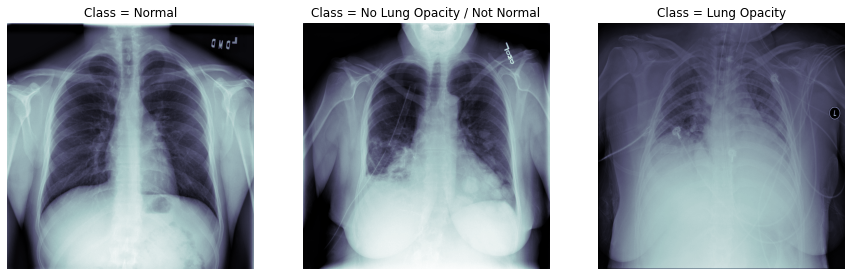

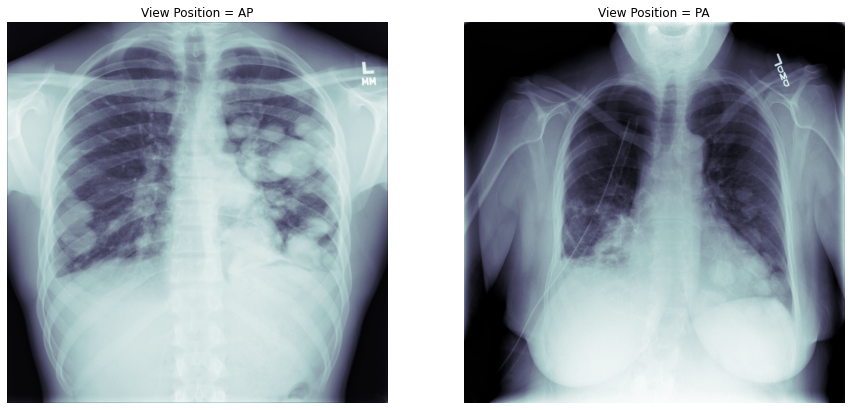

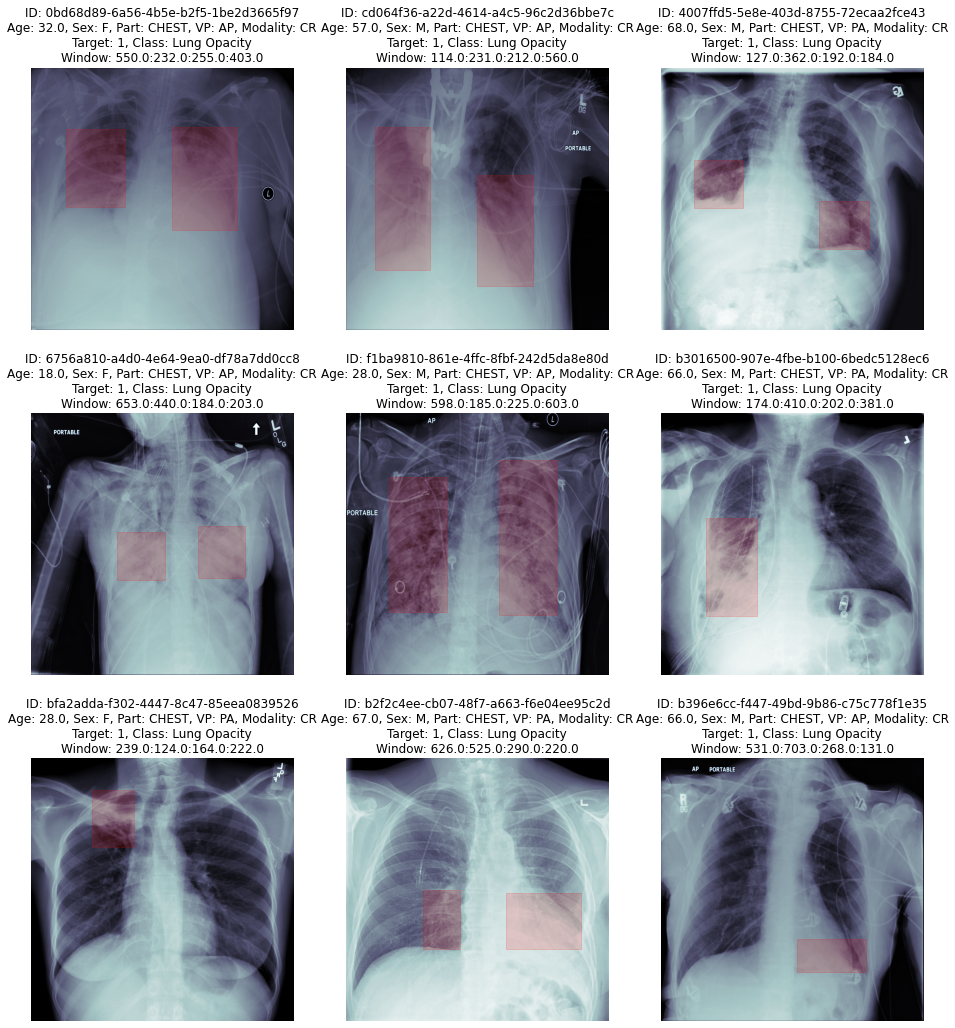

In [ ]:
from matplotlib.patches import Rectangle

print('Overall the distribution is almost equal for `ViewPosition` but where there\'s a Pneumonia Evidence, `ViewPosition` is `AP`')
print('AP: Anterior/Posterior, PA: Posterior/Anterior'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class_df['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'Distribution of ViewPosition, Overall', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class_df.loc[train_class_df['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'Distribution of ViewPosition, Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

print('Plot x and y centers of bounding boxes'); print('--'*40)
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class_df[train_class_df['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes, 
                  kind = 'hex', alpha = 0.5,)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

# Helper function to plot bboxes scatter
# Reference for this function & plots: https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

print('Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000')

df1 = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

print('Checking outliers in `PatientAge'); print('--'*40)
print('Minimum `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].min()))
print('Maximum `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].max()))
print('75th Percentile of `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].quantile(0.75)))
print('`PatientAge` in upper whisker for box plot: {}'.format(train_class_df['PatientAge'].quantile(0.75) + (train_class_df['PatientAge'].quantile(0.75) - train_class_df['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class_df['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

print('Using pd.clip to set upper threshold of 100 for age and remove outliers'); print('--'*40)
train_class_df['PatientAge'] = train_class_df['PatientAge'].clip(train_class_df['PatientAge'].min(), 100)
train_class_df['PatientAge'].describe().astype(int)

print('Get the distribution of `PatientAge` overall and where Target = 1'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.histplot(train_class_df['PatientAge'])
    .set_title('Distribution of PatientAge, Overall'))
ax = fig.add_subplot(122)
g = (sns.histplot(train_class_df.loc[train_class_df['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge, Pneumonia Evidence'))
print('Creating Age Binning field', '--'*40)
train_class_df['AgeBins'] = pd.cut(train_class_df['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class_df['AgeBins'].value_counts()

print('Value counts of the age bin field created'); print('--'*40)
display(pd.concat([train_class_df['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class_df.loc[train_class_df['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class_df['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class_df.loc[train_class_df['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

print('Exploring the bounding boxes centers for `AgeBins` for random sample = 200')
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class_df[train_class_df['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '<=26'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')

print('Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender'); print('--'*40)
display(pd.concat([train_class_df['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class_df.loc[(train_class_df['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.histplot(train_class_df.loc[(train_class_df['Target'] == 1) & (train_class_df['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.histplot(train_class_df.loc[(train_class_df['Target'] == 1) & (train_class_df['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class_df['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class_df.loc[(train_class_df['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

print('Exploring the bounding boxes centers for `PatientSex` for random sample = 1000')
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

# train_class_df.drop(['BodyPartExamined', 'Modality', 'AgeBins'], inplace = True, axis = 1)
# train_class_df.to_pickle('/content/drive/MyDrive/Capstone-Pneumonia/train_class_features.pkl')
train_class_df = pd.read_pickle(images_path + '/../train_class_features.pkl')

display(train_class_df.shape, train_class_df.head())

print('Checking sample for different classes')
sample1 = train_class_df.query("`class` == 'Normal'").iloc[0]
sample2 = train_class_df.query("`class` == 'No Lung Opacity / Not Normal'").iloc[0]
sample3 = train_class_df.query("`class` == 'Lung Opacity'").iloc[1]
ds1 = dicom.dcmread(images_path + '/stage_2_train_images/' + sample1['path'].split('/')[-1])
ds2 = dicom.dcmread(images_path + '/stage_2_train_images/' + sample2['path'].split('/')[-1])
ds3 = dicom.dcmread(images_path + '/stage_2_train_images/' + sample3['path'].split('/')[-1])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()

sample4 = train_class_df.loc[(train_class_df['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class_df.loc[(train_class_df['ViewPosition'] == 'PA')].iloc[0]
ds4 = dicom.dcmread(images_path + '/stage_2_train_images/' + sample4['path'].split('/')[-1])
ds5 = dicom.dcmread(images_path + '/stage_2_train_images/' + sample5['path'].split('/')[-1])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

# Helper function to plot the dicom images
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    #print(img_data)
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        #print(image)
        path = os.path.join(img_path, image)
        data = dicom.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = dicom.dcmread(path)
        #print(image)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'red', alpha = 0.15)) 
    plt.show()

# this function is a part of custom module imported earlier (`eda`)
plot_dicom_images(data = train_class_df.loc[(train_class_df['Target'] == 1)].sample(9), 
                  df = train_class_df, img_path = TRAIN_IMG_DCM)

## Step 5: Display images with bounding box.

0  1  2
10  1  0  0
21  1  0  0
24  1  0  0
28  1  0  0
29  1  0  0

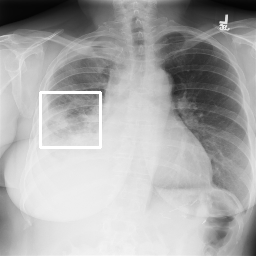

In [ ]:
#writing a helper function to get the box coordinates
def img_box_coordinates_from_idx(idx):
  file_name = os.path.splitext(fn[idx])[0]
  cordn = df1A[df1A['patientId'] == file_name].iloc[0][1:5]
  return cordn

def img_box_coordinates (x, y, w, h):
  points = []
  coord = []
  if x == np.NaN:
    return points, coord
  
  x1 = int(x) #upper left
  y1 = int(y)
  x2 = int(x) #bottom left
  y2 = int(y+h)
  x3 = int(x+w) #bottom right
  y3 = int(y+h)
  x4 = int(x+w) #upper right
  y4 = int(y)
  points.append(np.array([[x1,y1], [x2,y2], [x3,y3], [x4,y4]]))
  coord.append([[x1,y1],[x3,y3]])
  return points, coord

#take a random image
display(Y_dash[Y_dash[0] == 1].head())
img_num = 28 #pick any index in Y_dash with Lung Opacity as 1

img = X[img_num]
#get the box parameters x,y,w,h
lt = img_box_coordinates_from_idx(img_num)
_, pt = img_box_coordinates(lt[0], lt[1], lt[2], lt[3])
#put a box on the image
factor = 256/1024 #doing this as the original res. was 1024x1024 and we resized to 256x256
img = cv2.rectangle(img, 
                    [int(a) for a in np.multiply(pt[0][0],factor)], 
                    [int(b) for b in np.multiply(pt[0][1],factor)], 
                    (255,255,255), 2)
cv2_imshow(img)


## Step 6: Design, train and test basic CNN models for classification.

In [ ]:
#start with lenet-5CNN for basic Classification task - dont bother about bounding box here
print("X train shape ", X_train.shape)
print("Y train shape ", Y_train.shape)
print("X test shape ", X_test.shape)
print("Y test shape ", Y_test.shape)

def basic_CNN():
  model = Sequential()
  model.add(Conv2D(filters = 6, kernel_size = (5, 5), input_shape=(256,256,1), activation = 'relu'))
  model.add(AveragePooling2D())
  model.add(Conv2D(filters = 16, kernel_size = (5, 5), activation = 'relu'))
  model.add(AveragePooling2D())
  model.add(Flatten())
  model.add(Dense(units = 120, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(units = 84, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(units = 3, activation = 'softmax'))  
  return model

model = basic_CNN()
model.summary()
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print("Model compiled!")

X train shape  (21347, 256, 256, 1)
Y train shape  (21347, 3)
X test shape  (5337, 256, 256, 1)
Y test shape  (5337, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 6)       156       
                                                                 
 average_pooling2d (AverageP  (None, 126, 126, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 61, 61, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 59536)             0         


Epoch 1/30
84/84 [==============================] - 8s 35ms/step - loss: 0.9572 - accuracy: 0.5470 - val_loss: 1.3201 - val_accuracy: 0.5252
Epoch 2/30
84/84 [==============================] - 2s 27ms/step - loss: 0.8178 - accuracy: 0.6116 - val_loss: 1.1019 - val_accuracy: 0.5156
Epoch 3/30
84/84 [==============================] - 2s 28ms/step - loss: 0.7721 - accuracy: 0.6337 - val_loss: 1.8134 - val_accuracy: 0.4006
Epoch 4/30
84/84 [==============================] - 2s 27ms/step - loss: 0.7219 - accuracy: 0.6696 - val_loss: 1.0853 - val_accuracy: 0.5089
Epoch 5/30
84/84 [==============================] - 2s 27ms/step - loss: 0.6408 - accuracy: 0.7173 - val_loss: 1.4052 - val_accuracy: 0.5052
Epoch 6/30
84/84 [==============================] - 2s 27ms/step - loss: 0.5493 - accuracy: 0.7647 - val_loss: 1.1785 - val_accuracy: 0.5095
Epoch 7/30
84/84 [==============================] - 2s 27ms/step - loss: 0.4267 - accuracy: 0.8285 - val_loss: 1.0886 - val_accuracy: 0.5473
Epoch 8/30
84

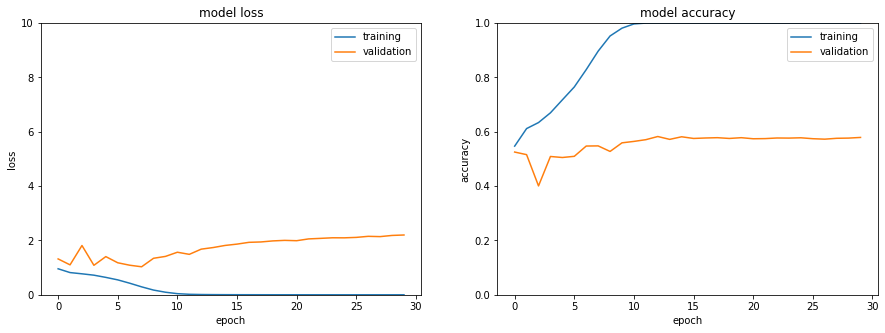

In [ ]:
history1 = model.fit(X_train, Y_train, batch_size=256, epochs=30, validation_data = (X_test,Y_test))

fig, axis = plt.subplots(1,2, figsize=(15,5))
axis[0].plot(history1.history['loss'])
axis[0].plot(history1.history['val_loss'])
axis[0].set_title('model loss')
axis[0].set_ylabel('loss')
axis[0].set_xlabel('epoch')
axis[0].legend(['training', 'validation'], loc='best')
axis[0].set_ylim(0, 10)

axis[1].plot(history1.history['accuracy'])
axis[1].plot(history1.history['val_accuracy'])
axis[1].set_title('model accuracy')
axis[1].set_ylabel('accuracy')
axis[1].set_xlabel('epoch')
axis[1].legend(['training', 'validation'], loc='best')
axis[1].set_ylim(0, 1)

plt.show()

#pickle the file only once, if not retuning there after.
# pickle.dump(model, open(images_path + 'model_basic_CNN_lenet.pkl', 'wb'))

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-13 11:46:50           64
config.json                                    2023-03-13 11:46:50         5061
variables.h5                                   2023-03-13 11:46:50     85943320
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......average_pooling2d
.........vars
......average_pooling2d_1
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......flatten
.........va

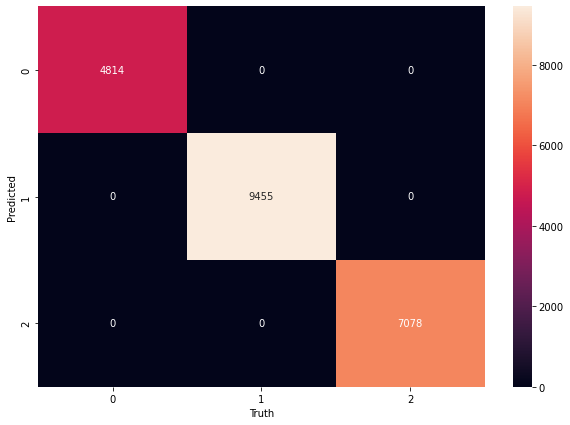

167/167 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.47      0.41      0.44      1198
           1       0.56      0.59      0.57      2366
           2       0.66      0.69      0.67      1773

    accuracy                           0.58      5337
   macro avg       0.57      0.56      0.56      5337
weighted avg       0.57      0.58      0.58      5337



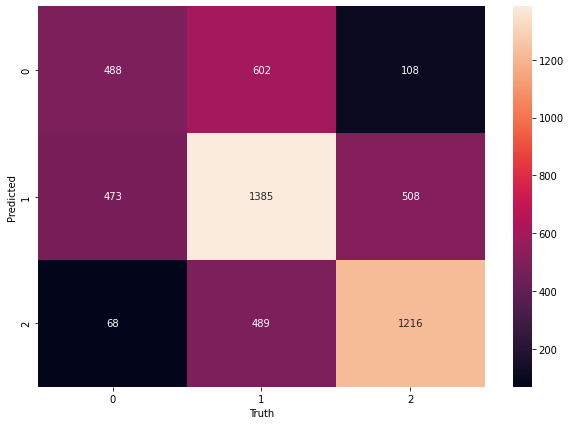

In [ ]:
#metrics for the training data
pickled_model = pickle.load(open(images_path + 'model_basic_CNN_lenet.pkl', 'rb'))

y_pred = pickled_model.predict(X_train)
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

Y_train_true = Y_train.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(Y_train_true, y_pred_final))
cm=confusion_matrix(Y_train_true, y_pred_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()
#get the accuracy no.s
train_acc = cm.diagonal()/cm.sum(axis=1)
train_acc_overall = accuracy_score(Y_train_true, y_pred_final)

#metrics for the test data -> this data we have not seen yet.
y_pred_test = pickled_model.predict(X_test)
y_pred_test_final=[]
for i in y_pred_test:
  #index 0 is 'Lung Opacity', 1 is 'Normal' or 'No Pnemonia'
  y_pred_test_final.append(np.argmax(i))

Y_test_true = Y_test.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(Y_test_true, y_pred_test_final))
cm=confusion_matrix(Y_test_true, y_pred_test_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

#get the accuracy no.s
test_acc = cm.diagonal()/cm.sum(axis=1)
test_acc_overall = accuracy_score(Y_test_true, y_pred_test_final)

#Put the model and Accuracy figures for test and train data in a dataframe
perf_dict = {'Model':'CNN Lenet'}
perf_dict['Tr_Acc Overall '] = train_acc_overall
for i in range(len(train_acc)):
  perf_dict['Tr_Acc ' + list(le.classes_)[i]] = train_acc[i]
perf_dict['Ts_Acc Overall '] = test_acc_overall
for i in range(len(test_acc)):
  perf_dict['Ts_Acc ' + list(le.classes_)[i]] = test_acc[i]

df_results = pd.DataFrame(perf_dict, index=[0])
df_results.to_excel(images_path + 'df_results.xlsx', index=False)

# Milestone 2

## Step 1: Fine tune the trained basic CNN models for classification.

### CNN tuned

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_203 (Conv2D)         (None, 254, 254, 8)       80        
                                                                 
 batch_normalization_204 (Ba  (None, 254, 254, 8)      32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 conv2d_204 (Conv2D)         (None, 125, 125, 32)      2336      
                                                                 
 batch_normalization_205 (Ba  (None, 125, 125, 32)     128       
 tchNormalization)                                               
                                                      

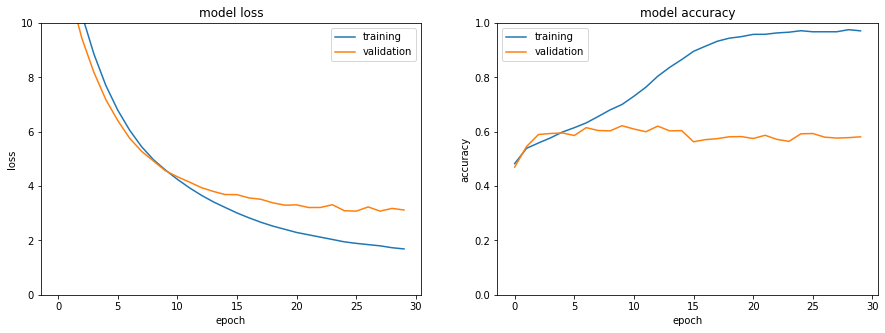

In [ ]:
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# datagen.fit(X_train)
# print("Shape of training set ", X_train.shape)

def tuned_basic_CNN():
  model = Sequential()
  model.add(Conv2D(filters = 8, kernel_size = (3, 3), input_shape=(256,256,1), activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Flatten())
  model.add(Dense(units = 256, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(units = 32, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(units = 3, activation = 'softmax', kernel_initializer='he_normal'))
  
  # model = Sequential()
  # model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape=(256,256,1), activation = 'relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size = (2, 2)))
  # model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size = (2, 2)))
  # model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size = (2, 2)))
  # model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size = (2, 2)))
  # model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size = (2, 2)))
  # model.add(Flatten())
  # model.add(Dense(units = 256, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # # model.add(Dense(units = 128, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.4))
  # model.add(Dense(units = 64, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.4))
  # model.add(Dense(units = 16, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.4))
  # model.add(Dense(units = 3, activation = 'softmax'))
  return model

model_tuned = tuned_basic_CNN()
model_tuned.summary()
opt = optimizers.Adam(learning_rate=0.0001)
model_tuned.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# history2 = model_tuned.fit_generator(datagen.flow(X_train,Y_train, batch_size=256),
#                               epochs = 30, validation_data = (X_test,Y_test),
#                               verbose = 1, callbacks=[earlystop])

history2 = model_tuned.fit(X_train, Y_train, batch_size=256, epochs=30, validation_data = (X_test,Y_test))

fig, axis = plt.subplots(1,2, figsize=(15,5))
axis[0].plot(history2.history['loss'])
axis[0].plot(history2.history['val_loss'])
axis[0].set_title('model loss')
axis[0].set_ylabel('loss')
axis[0].set_xlabel('epoch')
axis[0].legend(['training', 'validation'], loc='best')
axis[0].set_ylim(0, 10)

axis[1].plot(history2.history['accuracy'])
axis[1].plot(history2.history['val_accuracy'])
axis[1].set_title('model accuracy')
axis[1].set_ylabel('accuracy')
axis[1].set_xlabel('epoch')
axis[1].legend(['training', 'validation'], loc='best')
axis[1].set_ylim(0, 1)

plt.show()

#pickle the model if only doing inferences after that.
# pickle.dump(model_tuned, open(images_path + 'model_tuned_CNN.pkl', 'wb'))

#added one more CNN (64) with maxpooling -> 73% 61% NS
#all maxpooling, CNN(128) added -> 88%, 60% NS
#CNN 6/16/64/128 -> 6/30/90/150, FC is 128/16/3 -> 256/64/3; -> 96%, 58%
#regul. l1 -> 60%, 59%.. NS
#reverted to l2, increased lr to 0.001 -> 71%, 62%. NS

#expanded CNN's
#32,64,128 and 32,8,3 with batch-norm, dropout and adam-0.001, 98%accuracy but validation is 51%
#add kernel initialization, validation improved to ~60%.
#add 256 CNN and 128 Dense -> 98.4% train accuracy, 60% validation accuracy
#target is now only 0/1.. dense is 256/64/16/2..16M parms to train. got 99.4% train and upto 78-80% test accuracy
#added 512 CNN.. reduced trainable parms to 10M.. 99.3%, 77% accuracy
#added l2 regularization.. 82%, 74%
#with l1.. 79%, 67%


Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-13 15:34:34           64
config.json                                    2023-03-13 15:34:34         9430
variables.h5                                   2023-03-13 15:34:36    158362920
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......batch_normalization_4
.........vars
............0
............1
............2
............3
......batch_normalization_5
.........vars
............0
............1
............2
...

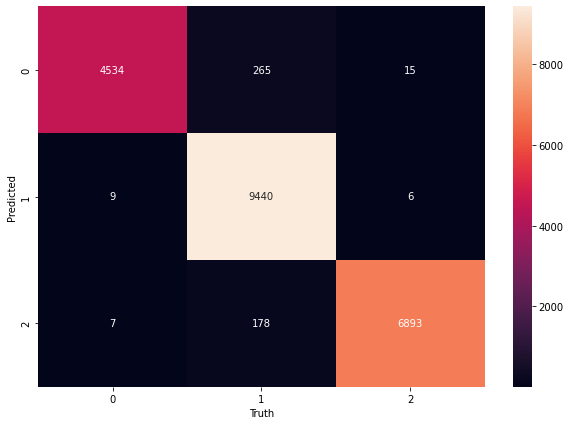

167/167 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.28      0.50      0.36       668
           1       0.73      0.54      0.62      3180
           2       0.59      0.70      0.64      1489

    accuracy                           0.58      5337
   macro avg       0.53      0.58      0.54      5337
weighted avg       0.63      0.58      0.59      5337



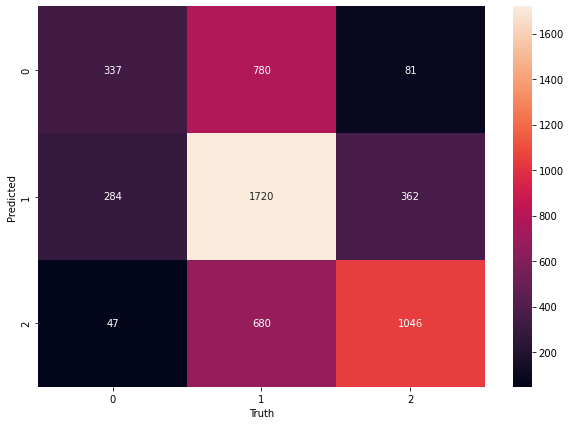

In [ ]:
#Results from tuned model
pickled_model_tuned_CNN = pickle.load(open(images_path + 'model_tuned_CNN.pkl', 'rb'))

y_pred = pickled_model_tuned_CNN.predict(X_train)
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

Y_train_true = Y_train.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(y_pred_final, Y_train_true))
cm=confusion_matrix(Y_train_true, y_pred_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

train_acc = cm.diagonal()/cm.sum(axis=1)
train_acc_overall = accuracy_score(Y_train_true, y_pred_final)

#metrics for the test data -> this data we have not seen yet.
y_pred_test = pickled_model_tuned_CNN.predict(X_test)
y_pred_test_final=[]
for i in y_pred_test:
  #index 0 is 'Lung Opacity', 1 is 'Normal' or 'No Pnemonia'
  y_pred_test_final.append(np.argmax(i))

Y_test_true = Y_test.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(y_pred_test_final, Y_test_true))
cm=confusion_matrix(Y_test_true, y_pred_test_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

#get the accuracy no.s
test_acc = cm.diagonal()/cm.sum(axis=1)
test_acc_overall = accuracy_score(Y_test_true, y_pred_test_final)

#Put the model and Accuracy figures for test and train data in a dataframe
perf_dict = {'Model':'CNN Tuned'}
perf_dict['Tr_Acc Overall '] = train_acc_overall
for i in range(len(train_acc)):
  perf_dict['Tr_Acc ' + list(le.classes_)[i]] = train_acc[i]
perf_dict['Ts_Acc Overall '] = test_acc_overall
for i in range(len(test_acc)):
  perf_dict['Ts_Acc ' + list(le.classes_)[i]] = test_acc[i]

df_results = pd.read_excel(images_path + 'df_results.xlsx')
df_results.loc[len(df_results.index)] = list(perf_dict.values())
df_results.to_excel(images_path + 'df_results.xlsx', index=False)

## Step 2: Apply Transfer Learning model for classification

###Resnet50

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 64)                8388672   
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 19

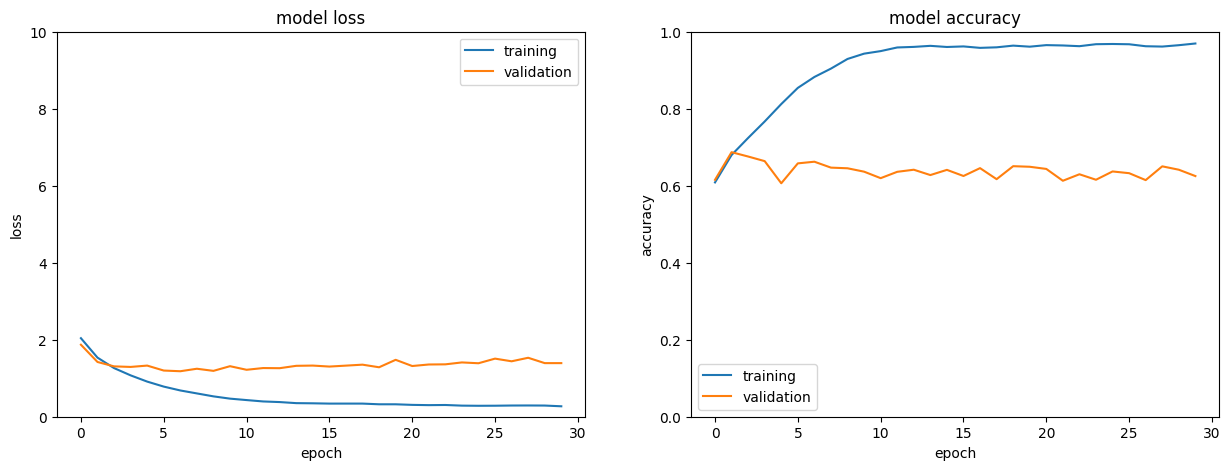

In [ ]:
# Transfer learning - Resnet
from tensorflow.keras.applications.resnet50 import preprocess_input

X_train_rs = preprocess_input(X_train_rgb) 
X_test_rs = preprocess_input(X_test_rgb)

def CNN_with_resnet():
  model = Sequential()
  base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train_rs[0].shape)
  base_model.trainable = False ## Not trainable weights
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(units = 64, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(units = 3, activation = 'softmax', kernel_initializer='he_normal'))
  return model

model_CNN_resnet = CNN_with_resnet()
model_CNN_resnet.summary()
opt = optimizers.Adam(learning_rate=0.0001)
model_CNN_resnet.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history3 = model_CNN_resnet.fit(X_train_rs, Y_train, batch_size=256, epochs=30, validation_data = (X_test_rs,Y_test))

fig, axis = plt.subplots(1,2, figsize=(15,5))
axis[0].plot(history3.history['loss'])
axis[0].plot(history3.history['val_loss'])
axis[0].set_title('model loss')
axis[0].set_ylabel('loss')
axis[0].set_xlabel('epoch')
axis[0].legend(['training', 'validation'], loc='best')
axis[0].set_ylim(0, 10)

axis[1].plot(history3.history['accuracy'])
axis[1].plot(history3.history['val_accuracy'])
axis[1].set_title('model accuracy')
axis[1].set_ylabel('accuracy')
axis[1].set_xlabel('epoch')
axis[1].legend(['training', 'validation'], loc='best')
axis[1].set_ylim(0, 1)

plt.show()

#pickle it only once.. once saved, use the model for inferences
pickle.dump(model_CNN_resnet, open(images_path + 'model_TL_Resnet50.pkl', 'wb'))
from tensorflow.keras.models import save_model, load_model
save_model(model_CNN_resnet, images_path + "model_TL_Resnet50.h5")

# resnet -> 97%, 59%

In [ ]:
from tensorflow.keras.models import save_model, load_model
save_model(model_CNN_resnet, images_path + "model_TL_Resnet50.h5")
pickled_model_resnet = load_model(images_path + 'model_TL_Resnet50.h5')

668/668 [==============================] - 16s 22ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4891
           1       0.99      1.00      0.99      9340
           2       1.00      0.99      1.00      7116

    accuracy                           0.99     21347
   macro avg       0.99      0.99      0.99     21347
weighted avg       0.99      0.99      0.99     21347



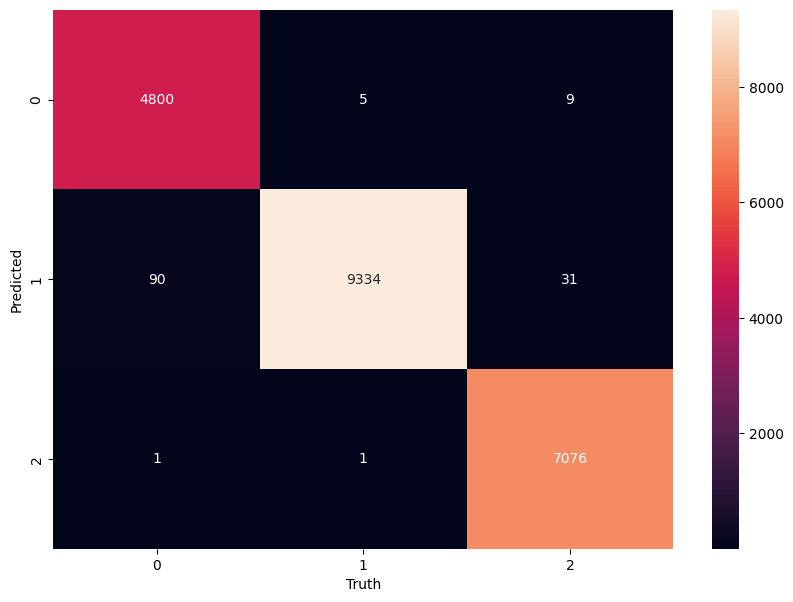

167/167 [==============================] - 4s 24ms/step
              precision    recall  f1-score   support

           0       0.54      0.51      0.52      1276
           1       0.55      0.62      0.58      2091
           2       0.79      0.71      0.74      1970

    accuracy                           0.63      5337
   macro avg       0.62      0.61      0.62      5337
weighted avg       0.63      0.63      0.63      5337



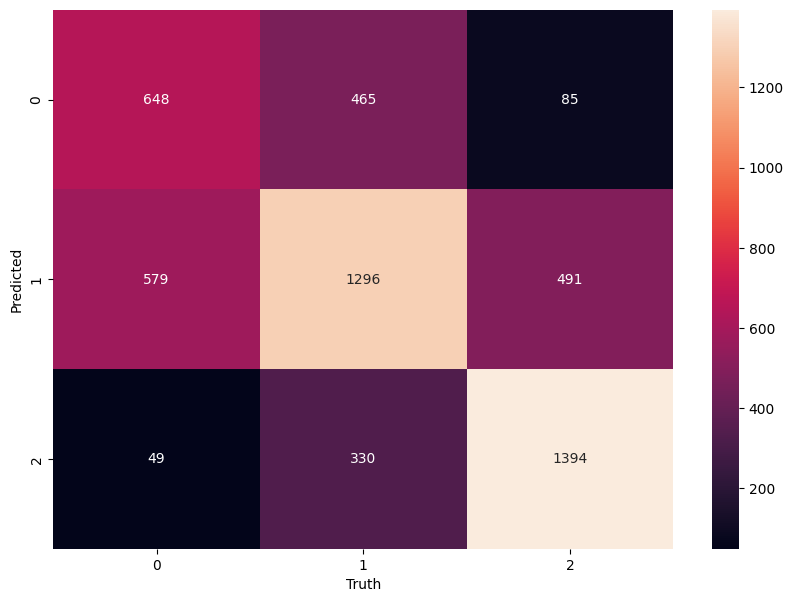

In [ ]:
#Resnet - train data
from tensorflow.keras.applications.resnet50 import preprocess_input

#load data if using pickle
X_train_rs = preprocess_input(X_train_rgb) 
X_test_rs = preprocess_input(X_test_rgb)
pickled_model_resnet = pickle.load(open(images_path + 'model_TL_Resnet50.pkl', 'rb'))
pickled_model_resnet = load_model(images_path + 'model_TL_Resnet50.h5')

y_pred = pickled_model_resnet.predict(X_train_rs)
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

Y_train_true = Y_train.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(y_pred_final, Y_train_true))
cm=confusion_matrix(Y_train_true, y_pred_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

#get the accuracy no.s
train_acc = cm.diagonal()/cm.sum(axis=1)
train_acc_overall = accuracy_score(Y_train_true, y_pred_final)

#metrics for the test data -> this data we have not seen yet.
y_pred_test = pickled_model_resnet.predict(X_test_rs)
y_pred_test_final=[]
for i in y_pred_test:
  #index 0 is 'Lung Opacity', 1 is 'Normal' or 'No Pnemonia'
  y_pred_test_final.append(np.argmax(i))

Y_test_true = Y_test.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(y_pred_test_final, Y_test_true))
cm=confusion_matrix(Y_test_true, y_pred_test_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

#get the accuracy no.s
test_acc = cm.diagonal()/cm.sum(axis=1)
test_acc_overall = accuracy_score(Y_test_true, y_pred_test_final)

#Put the model and Accuracy figures for test and train data in a dataframe
perf_dict = {'Model':'TL Resnet50'}
perf_dict['Tr_Acc Overall '] = train_acc_overall
for i in range(len(train_acc)):
  perf_dict['Tr_Acc ' + list(le.classes_)[i]] = train_acc[i]
perf_dict['Ts_Acc Overall '] = test_acc_overall
for i in range(len(test_acc)):
  perf_dict['Ts_Acc ' + list(le.classes_)[i]] = test_acc[i]

df_results = pd.read_excel(images_path + 'df_results.xlsx')
df_results.loc[len(df_results.index)] = list(perf_dict.values())
df_results.to_excel(images_path + 'df_results.xlsx', index=False)

###VGGNet16

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

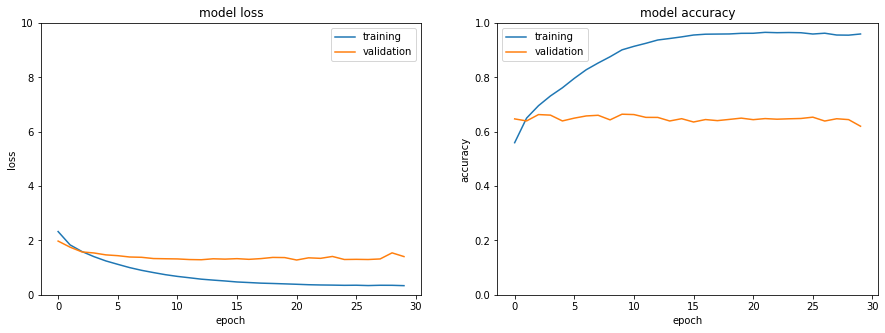

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......functional
.........layers
............conv2d
...............vars
..................0
..................1
............conv2d_1
...............vars
..................0
..................1
............conv2d_10
...............vars
..................0
..................1
............conv2d_11
...............vars
..................0
..................1
............conv2d_12
...............vars
..................0
..................1
............conv2d_2
...............vars
..................0
..................1
............conv2d_3
...............vars
..................0
..................1
............conv2d_4
...............vars
..................0


In [ ]:
#Transfer learning - Vggnet
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train_vgg = preprocess_input(X_train_rgb) 
X_test_vgg = preprocess_input(X_test_rgb)

def CNN_with_Vggnet():
  model = Sequential()
  base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train_vgg[0].shape)
  base_model.trainable = False ## Not trainable weights
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(units = 64, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(units = 3, activation = 'softmax', kernel_initializer='he_normal'))
  return model

model_CNN_vggnet = CNN_with_Vggnet()
model_CNN_vggnet.summary()
opt = optimizers.Adam(learning_rate=0.0001)
model_CNN_vggnet.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# earlystop= EarlyStopping(monitor='val_loss', patience=3)

history4 = model_CNN_vggnet.fit(X_train_vgg, Y_train, batch_size=256, epochs=30, validation_data = (X_test_vgg,Y_test))

fig, axis = plt.subplots(1,2, figsize=(15,5))
axis[0].plot(history4.history['loss'])
axis[0].plot(history4.history['val_loss'])
axis[0].set_title('model loss')
axis[0].set_ylabel('loss')
axis[0].set_xlabel('epoch')
axis[0].legend(['training', 'validation'], loc='best')
axis[0].set_ylim(0, 10)

axis[1].plot(history4.history['accuracy'])
axis[1].plot(history4.history['val_accuracy'])
axis[1].set_title('model accuracy')
axis[1].set_ylabel('accuracy')
axis[1].set_xlabel('epoch')
axis[1].legend(['training', 'validation'], loc='best')
axis[1].set_ylim(0, 1)

plt.show()

#pickle only once, if you only want to make inferences after that
# pickle.dump(model_CNN_vggnet, open(images_path + 'model_TL_Vgg16.pkl', 'wb'))

#VGG - 96%, 62%

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-13 10:28:28           64
config.json                                    2023-03-13 10:28:28        12709
variables.h5                                   2023-03-13 10:28:28     84105728
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......functional
.........layers
............conv2d
...............vars
..................0
..................1
............conv2d_1
...............vars
..................0
..................1
............conv2d_10
...............vars
..................0
..................1
............conv2d_11
...............v

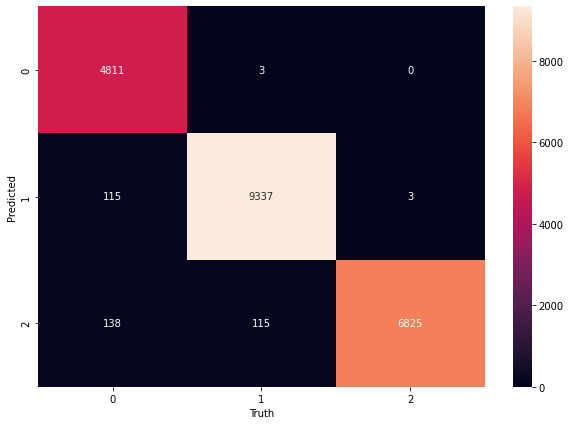

167/167 [==============================] - 4s 25ms/step
              precision    recall  f1-score   support

           0       0.59      0.45      0.51      1561
           1       0.60      0.62      0.61      2288
           2       0.67      0.80      0.73      1488

    accuracy                           0.62      5337
   macro avg       0.62      0.62      0.62      5337
weighted avg       0.62      0.62      0.61      5337



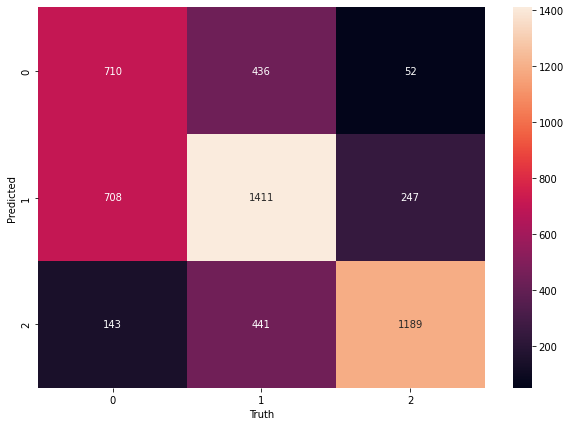

In [ ]:
#VGG - train data
from tensorflow.keras.applications.vgg16 import preprocess_input
pickled_model_vgg16 = pickle.load(open(images_path + 'model_TL_Vgg16.pkl', 'rb'))
X_train_vgg = preprocess_input(X_train_rgb) 
X_test_vgg = preprocess_input(X_test_rgb)

y_pred = pickled_model_vgg16.predict(X_train_vgg)
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

Y_train_true = Y_train.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(y_pred_final, Y_train_true))
cm=confusion_matrix(Y_train_true, y_pred_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

#get the accuracy no.s
train_acc = cm.diagonal()/cm.sum(axis=1)
train_acc_overall = accuracy_score(Y_train_true, y_pred_final)

#metrics for the test data -> this data we have not seen yet.
y_pred_test = pickled_model_vgg16.predict(X_test_vgg)
y_pred_test_final=[]
for i in y_pred_test:
  #index 0 is 'Lung Opacity', 1 is 'Normal' or 'No Pnemonia'
  y_pred_test_final.append(np.argmax(i))

Y_test_true = Y_test.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(y_pred_test_final, Y_test_true))
cm=confusion_matrix(Y_test_true, y_pred_test_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

#get the accuracy no.s
test_acc = cm.diagonal()/cm.sum(axis=1)
test_acc_overall = accuracy_score(Y_test_true, y_pred_test_final)

#Put the model and Accuracy figures for test and train data in a dataframe
perf_dict = {'Model':'TL Vgg16'}
perf_dict['Tr_Acc Overall '] = train_acc_overall
for i in range(len(train_acc)):
  perf_dict['Tr_Acc ' + list(le.classes_)[i]] = train_acc[i]
perf_dict['Ts_Acc Overall '] = test_acc_overall
for i in range(len(test_acc)):
  perf_dict['Ts_Acc ' + list(le.classes_)[i]] = test_acc[i]

df_results = pd.read_excel(images_path + 'df_results.xlsx')
df_results.loc[len(df_results.index)] = list(perf_dict.values())
df_results.to_excel(images_path + 'df_results.xlsx', index=False)

###InceptionV2

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 55296)             0         
                                                                 
 dense (Dense)               (None, 64)                3539008   
                                                                 
 batch_normalization_203 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                       

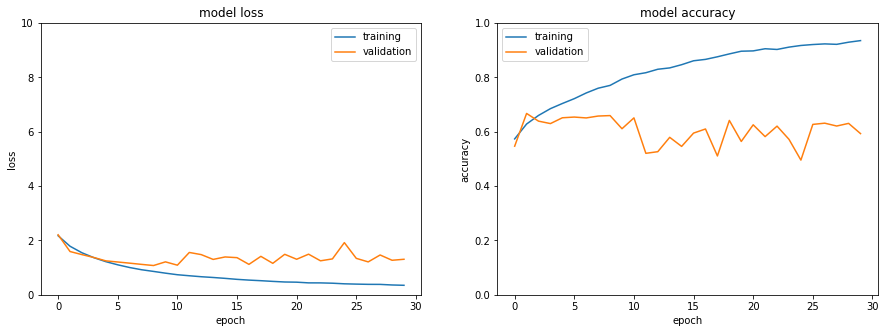

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............activation_10
...............vars
............activation_100
...............vars
............activation_101
...............vars
............activation_102
...............vars
............activation_103
...............vars
............activation_104
...............vars
............activation_105
...............vars
............activation_106
...............vars
............activation_107
...............vars
............activation_108
...............vars
............activation_109
...............vars
............activation_11

In [ ]:
#Transfer learning - InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

X_train_incepv2 = preprocess_input(X_train_rgb) 
X_test_incepv2 = preprocess_input(X_test_rgb)

def CNN_with_InceptionV2():
  model = Sequential()
  base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=X_train_incepv2[0].shape)
  base_model.trainable = False ## Not trainable weights
  # for layer in base_model.layers:
  #   layer.trainable = False
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(units = 64, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(units = 3, activation = 'softmax', kernel_initializer='he_normal'))
  return model

model_CNN_InceptionV2 = CNN_with_InceptionV2()
model_CNN_InceptionV2.summary()
opt = optimizers.Adam(learning_rate=0.0001)
model_CNN_InceptionV2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history5 = model_CNN_InceptionV2.fit(X_train_incepv2, Y_train, batch_size=256, epochs=30, validation_data = (X_test_incepv2,Y_test))

fig, axis = plt.subplots(1,2, figsize=(15,5))
axis[0].plot(history5.history['loss'])
axis[0].plot(history5.history['val_loss'])
axis[0].set_title('model loss')
axis[0].set_ylabel('loss')
axis[0].set_xlabel('epoch')
axis[0].legend(['training', 'validation'], loc='best')
axis[0].set_ylim(0, 10)

axis[1].plot(history5.history['accuracy'])
axis[1].plot(history5.history['val_accuracy'])
axis[1].set_title('model accuracy')
axis[1].set_ylabel('accuracy')
axis[1].set_xlabel('epoch')
axis[1].legend(['training', 'validation'], loc='best')
axis[1].set_ylim(0, 1)

plt.show()

#pickle only once, if you only want to make inferences after that
# pickle.dump(model_CNN_InceptionV2, open(images_path + 'model_TL_InceptionV2.pkl', 'wb'))


Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-13 15:13:04           64
config.json                                    2023-03-13 15:13:04       380817
variables.h5                                   2023-03-13 15:13:06    261701504
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............activation_10
...............vars
............activation_100
...............vars
............activation_101
...............vars
............activation_102
...............vars
.....

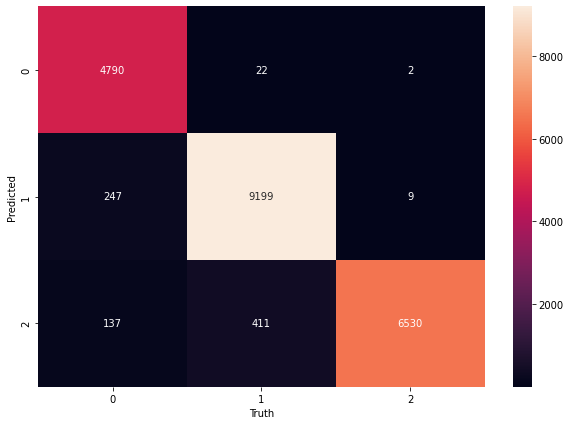

167/167 [==============================] - 8s 50ms/step
              precision    recall  f1-score   support

           0       0.56      0.43      0.48      1554
           1       0.59      0.58      0.58      2405
           2       0.63      0.81      0.71      1378

    accuracy                           0.59      5337
   macro avg       0.59      0.60      0.59      5337
weighted avg       0.59      0.59      0.58      5337



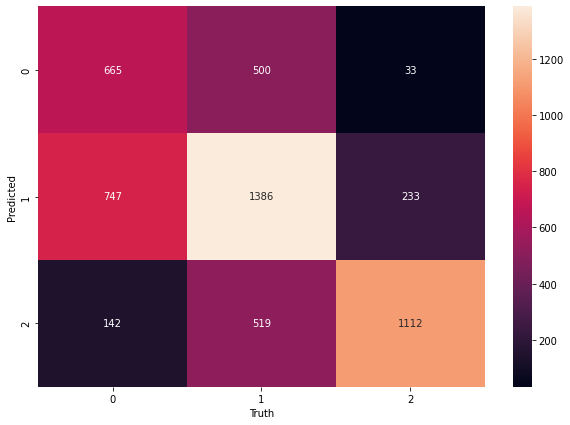

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

pickled_model_inceptionv2 = pickle.load(open(images_path + 'model_TL_InceptionV2.pkl', 'rb'))
X_train_incepv2 = preprocess_input(X_train_rgb) 
X_test_incepv2 = preprocess_input(X_test_rgb)

y_pred = pickled_model_inceptionv2.predict(X_train_incepv2)
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

Y_train_true = Y_train.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(y_pred_final, Y_train_true))
cm=confusion_matrix(Y_train_true, y_pred_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

#get the accuracy no.s
train_acc = cm.diagonal()/cm.sum(axis=1)
train_acc_overall = accuracy_score(Y_train_true, y_pred_final)

#metrics for the test data -> this data we have not seen yet.
y_pred_test = pickled_model_inceptionv2.predict(X_test_incepv2)
y_pred_test_final=[]
for i in y_pred_test:
  #index 0 is 'Lung Opacity', 1 is 'Normal' or 'No Pnemonia'
  y_pred_test_final.append(np.argmax(i))

Y_test_true = Y_test.idxmax(axis=1)

#This is for all the training data (includes the validation data during the training)
print(classification_report(y_pred_test_final, Y_test_true))
cm=confusion_matrix(Y_test_true, y_pred_test_final)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

#get the accuracy no.s
test_acc = cm.diagonal()/cm.sum(axis=1)
test_acc_overall = accuracy_score(Y_test_true, y_pred_test_final)

#Put the model and Accuracy figures for test and train data in a dataframe
perf_dict = {'Model':'TL InceptionV2'}
perf_dict['Tr_Acc Overall '] = train_acc_overall
for i in range(len(train_acc)):
  perf_dict['Tr_Acc ' + list(le.classes_)[i]] = train_acc[i]
perf_dict['Ts_Acc Overall '] = test_acc_overall
for i in range(len(test_acc)):
  perf_dict['Ts_Acc ' + list(le.classes_)[i]] = test_acc[i]

df_results = pd.read_excel(images_path + 'df_results.xlsx')
df_results.loc[len(df_results.index)] = list(perf_dict.values())
df_results.to_excel(images_path + 'df_results.xlsx', index=False)

###Classification Model Results

In [ ]:
#Put together classification model results

#pull results from the file.
df_results = pd.read_excel(images_path + 'df_results.xlsx')
#keep only the last save model results
df_results = df_results.drop_duplicates(subset=['Model'], keep='last')
df_results = df_results.sort_values(by=['Ts_Acc Overall '], ascending = False)

from IPython.display import display, HTML
display(HTML(df_results[['Model', 'Tr_Acc Overall ', 'Ts_Acc Overall ']].to_html(index=False)))
display(HTML(df_results.to_html(index=False)))

## Step 3: Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest.

### RCNN - Selective Search

Original Image  9563


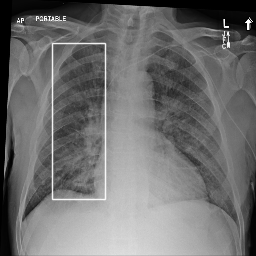

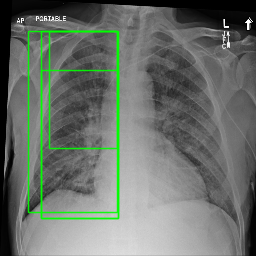

No. of BBs:  4 , iou  0.5742065421209807 , regions  313


In [ ]:
# What we can try are 
# 1. selective-search ref. RCNN.ipynb, 
# 2. faster RCNN with gluoncv library - ref Faster_RCNN_Resnet.ipynb,
# 3. UNET/segmentation -> do with a binary mask image as the output (no confidence and BB's as expected in output file)

#1. RCNN - selective search
import random
def calculate_iou(bb_1, bb_2):
    '''
  Now we are initialising the function to calculate IOU (Intersection Over Union) 
  of the ground truth box from the box computed by selective search.
  To divide the generated ROI’s, for example, we can use a metric called IoU. 
  It’s defined as the intersection area divided by area of the union of a predicted 
  bounding box and ground-truth box.
  '''
  
    assert bb_1['x1'] < bb_1['x2']    # The assert keyword lets you test if a condition in your code returns True, 
    assert bb_1['y1'] < bb_1['y2']    # if not, the program will raise an AssertionError.
    assert bb_2['x1'] < bb_2['x2']
    assert bb_2['y1'] < bb_2['y2']

    x_left = max(bb_1['x1'], bb_2['x1'])
    y_top = max(bb_1['y1'], bb_2['y1'])
    x_right = min(bb_1['x2'], bb_2['x2'])
    y_bottom = min(bb_1['y2'], bb_2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)

    bb_1_area = (bb_1['x2'] - bb_1['x1']) * (bb_1['y2'] - bb_1['y1'])
    bb_2_area = (bb_2['x2'] - bb_2['x1']) * (bb_2['y2'] - bb_2['y1'])

    iou_value = intersection / float(bb_1_area + bb_2_area - intersection)
    assert iou_value >= 0.0
    assert iou_value <= 1.0
    return iou_value

MAX_REGION_PROPOSALS = 2000
cv2.setUseOptimized(True);
ss_object = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

num = 9563 # random.choice(Y_dash[Y_dash[0] == 1].index)
Y_dash[Y_dash[0] == 1].index
input_image = X[num] #to put the Region proposals
# fn_name = os.path.splitext(fn[num])[0] #index path to get the BB's from df.

input_image = np.repeat(input_image[..., np.newaxis], 3, -1)
input_image = np.squeeze(input_image)
lt = img_box_coordinates_from_idx(num)
# lt = df1A[df1A['patientId'] == fn_name].iloc[0][1:5]
factor = 256/1024 #doing this as the original res. was 1024x1024 and we resized to 256x256
value = {"x1":int(lt[0]*factor),
         "x2":int((lt[0]+lt[2])*factor),
         "y1":int(lt[1]*factor),
         "y2":int((lt[1]+lt[3])*factor)}
#Display the truth bounding boxes
print("Original Image ", num)
img = X[num] #to display the ground truth
img = cv2.rectangle(img, 
                    (value['x1'], value['y1']), 
                    (value['x2'], value['y2']), 
                    (255,0,255), 1, cv2.LINE_AA)
cv2_imshow(img)

ss_object.setBaseImage(input_image)
ss_object.switchToSelectiveSearchQuality()  #this method of createSelectiveSearchSegmentation()
results = ss_object.process()    # The output of the process is a set of a potential ROI’s, depending on the size of the base image
new_input_image = input_image.copy() # create copy of the base image
count = 0
iou_lst = []
for region, rect in (enumerate(results)):
    if region < MAX_REGION_PROPOSALS:  # Iterating over all the first 2000 results only which are passed by selective search
      x,y,w,h = rect           
      iou = calculate_iou(value,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
      iou_lst.append(iou)
      if iou > 0.50:
        count = count +1
        cv2.rectangle(new_input_image, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
cv2_imshow(new_input_image)
print("No. of BBs: ", count, ", iou ", np.max(iou_lst), ", regions ", region)
# sns.histplot(iou_lst)

#Most of the img's show no BB's from selective search.
#595 showed 4 BB's, 21928 showed 1 BB, 9563 showed 4, 18466 showed 2, 24826 showed 1, 3325 showed 3 :)

### Faster RCNN - Using gluoncv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
BB <class 'mxnet.ndarray.ndarray.NDArray'>
scores <class 'mxnet.ndarray.ndarray.NDArray'>
class_IDs <class 'mxnet.ndarray.ndarray.NDArray'>
(6000, 4)
(6000, 1)
(6000, 1)



[[0.49974477]]
<NDArray 1x1 @cpu(0)>


[[14.]]
<NDArray 1x1 @cpu(0)>


[[ 26.448029    1.5422974 596.3834    604.8087   ]]
<NDArray 1x4 @cpu(0)>

('aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor')

'person'

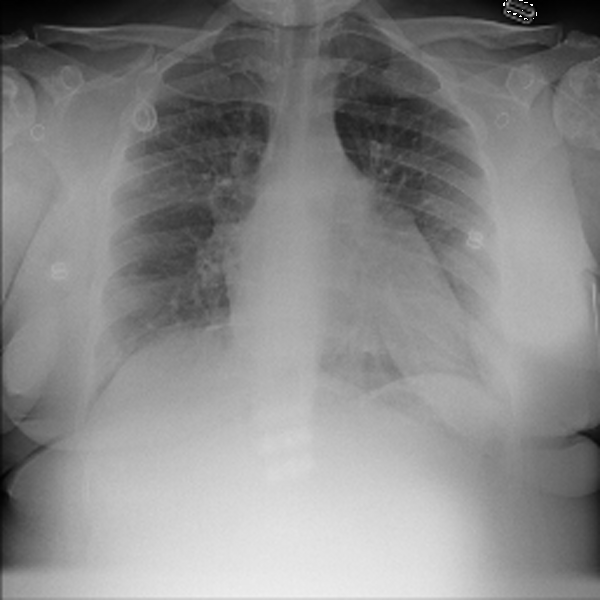

In [ ]:
#2: faster RCNN - gluoncv

!pip install gluoncv
!pip install mxnet
import mxnet as mx
import gluoncv
from gluoncv import model_zoo, data, utils
# get pretrained Faster RCNN with Resnet50 as base model v3 model from model_zoo class of gluoncv
net = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True)
final_array = mx.nd.array(X_train_rgb[0])        # convert the video frame into mxnet numpy array
x, img = gluoncv.data.transforms.presets.rcnn.transform_test(final_array)     # transform the array for model input shape
# print(type(final_array))
class_IDs, scores, bounding_boxes = net(x)            # get the class Ids, confidence scores and bounding boxes by passing the array through the model
ax = utils.viz.cv_plot_bbox(img, bounding_boxes[0], scores[0],
                          class_IDs[0], class_names=net.classes) # create an axis object with the information and respective classes
print("BB", type(bounding_boxes[0]))
print("scores", type(scores[0]))
print("class_IDs", type(class_IDs[0]))
print(bounding_boxes[0].shape)
print(scores[0].shape)
print(class_IDs[0].shape)
display(scores[0][np.argmax(scores[0])])
display(class_IDs[0][np.argmax(scores[0])])
display(bounding_boxes[0][np.argmax(scores[0])])
display(net.classes)
display(net.classes[14])
cv2_imshow(ax)

# Display the resulting image
# plt.rcParams['figure.figsize'] = [80, 50]
# plt.show(block=False)         
# plt.pause(0.0001)
# plt.close()

#what we will get in the class is 'person'.. We'll have to create a new class and retrain for our use-case.
#not proceeding with this method.

### UNET - Use binary segmentation for detection

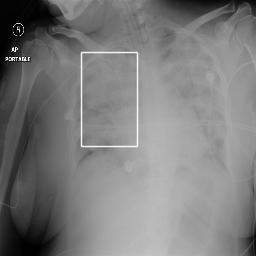

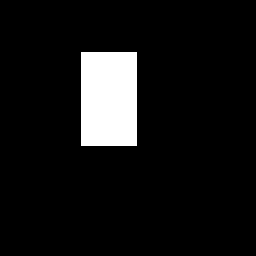

In [5]:
#3 UNET

#writing a helper function to get the box coordinates
def img_box_coordinates_from_idx(idx):
  file_name = os.path.splitext(fn[idx])[0]
  cordn = df1A[df1A['patientId'] == file_name].iloc[0][1:5]
  return cordn

def img_box_coordinates (x, y, w, h):
  points = []
  coord = []
  if x == np.NaN:
    return points, coord
  
  x1 = int(x) #upper left
  y1 = int(y)
  x2 = int(x) #bottom left
  y2 = int(y+h)
  x3 = int(x+w) #bottom right
  y3 = int(y+h)
  x4 = int(x+w) #upper right
  y4 = int(y)
  points.append(np.array([[x1,y1], [x2,y2], [x3,y3], [x4,y4]]))
  coord.append([[x1,y1],[x3,y3]])
  return points, coord

# Setup input/target. Input is fine, Output needs to be a binary mask image now.
# We need to run this only once - we have already done this now, and pickle'd the mask array.
# Y_mask = [0]*X.shape[0]
# # xx = {"x1":0,"x2":150,"y1":50,"y2":100}
# for idx in range(X.shape[0]):
#   Y_mask[idx] = np.zeros((256,256)) #X[idx].shape)
#   lt = img_box_coordinates_from_idx(idx)
#   factor = 256/1024 #doing this as the original res. was 1024x1024 and we resized to 256x256
#   if np.isnan(lt[0]) == False:
#     print("Index ", idx)
#     # print("lt (loop)", lt)
#     bb = {"x1":int(lt[0]*factor),
#             "x2":int((lt[0]+lt[2])*factor),
#             "y1":int(lt[1]*factor),
#             "y2":int((lt[1]+lt[3])*factor)}
#     Y_mask[idx][bb['y1']:bb['y2'], bb['x1']:bb['x2']] = 255
#     # Y_mask[idx][xx['x1']:xx['x2'], xx['y1']:xx['y2']] = 255
#     # print(bb)

# with open(images_path + 'outfile_Y_mask', 'wb') as fp:
#     pickle.dump(Y_mask, fp)

with open (images_path + 'outfile_Y_mask', 'rb') as fp:
    Y_mask = pickle.load(fp)
#we saved the mask as a list of array's. Making them arrays
Y_mask = np.stack(Y_mask, axis=0)
Y_mask = Y_mask/255 #Need to do this as the output in the UNET is a sigmoid for binary segmentation

#Sample image plots to show if mask img's are ok
img = np.copy(X[10])
lt = img_box_coordinates_from_idx(10)
factor = 256/1024 #doing this as the original res. was 1024x1024 and we resized to 256x256
val = {"x1":int(lt[0]*factor),
         "x2":int((lt[0]+lt[2])*factor),
         "y1":int(lt[1]*factor),
         "y2":int((lt[1]+lt[3])*factor)}
img = cv2.rectangle(img, 
                    (val['x1'], val['y1']), 
                    (val['x2'], val['y2']), 
                    (255,0,255), 1, cv2.LINE_AA)
cv2_imshow(img)
cv2_imshow(Y_mask[10]*255)

In [6]:
#Setup the UNET model

X_rgb = np.repeat(X[..., np.newaxis], 3, -1)
X_rgb = np.squeeze(X_rgb)

def unet_MN_based_model():
  inputs = Input(shape=(256, 256, 3), name='input_image')
  encoder = MobileNetV2(input_tensor=inputs, weights='imagenet', include_top=False, alpha=0.35)
  skip_connection_names = ['input_image','block_1_expand_relu','block_3_expand_relu','block_6_expand_relu']
  encoder_output = encoder.get_layer('block_13_expand_relu').output
  f = [16, 32, 48, 64]
  x = encoder_output
  for i in range(1,len(skip_connection_names)+1, 1):
    x_skip = encoder.get_layer(skip_connection_names[-i]).output
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, x_skip])
    x = Conv2D(f[-i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(f[-i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
  x = Conv2D(1, (1, 1), padding="same")(x)
  x = Activation("sigmoid")(x)
  model = Model(inputs, x)
  return model

model_unet = unet_MN_based_model()
model_unet.summary()

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

# def loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred) #- log(dice_coefficient(y_true, y_pred) + epsilon())

model_unet.compile(optimizer='Adam', loss=binary_crossentropy, metrics=[dice_coefficient])

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

#fit the model
model_unet.fit(X_rgb, Y_mask, batch_size=32, epochs=25, validation_split=0.1) 

2019640/2019640 [==============================] - 1s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 16  64          ['Conv1[0][0]']                  
                               

Xray id 921


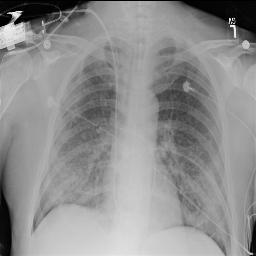

Truth


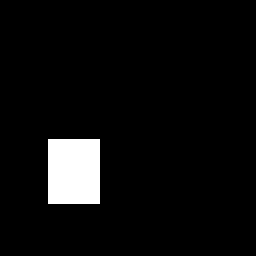

Prediction
1/1 [==============================] - 0s 28ms/step


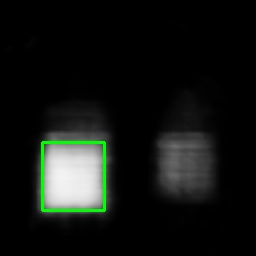

Predicted Pnemonia image with Bounding Box


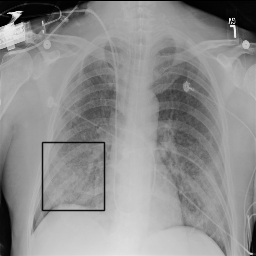

In [93]:
#Prediction a random sample image 
ids = list(Y_dash[Y_dash[0] == 1].index)
#from the list of pnemonia cases, randomly select one
id = rnd.choice(ids)
#26186, 22362, 22649, 12168, 23746, 21397, 12065, 14911, 17693, 9286 -> good prediction
#15808 -> faint
#9285 -> bad
print("Xray id", id)
cv2_imshow(X[id])
print("Truth")
cv2_imshow(Y_mask[id]*255)
print("Prediction")
pred_mask = np.squeeze(model_unet.predict(x=np.array([X_rgb[id]])))
# cv2_imshow(pred_mask*255)

gray = np.expand_dims(pred_mask*255, axis=-1)
gray = np.repeat(gray[..., np.newaxis], 3, -1)
gray = np.squeeze(gray)
gray = np.array(gray, np.uint8)
# gray = np.expand_dims(pred_mask*255, axis=-1)
gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
# apply thresholding on the gray image to create a binary image
ret,thresh = cv2.threshold(gray,127,255,0)
# find the contours
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# take the first contour
if len(contours) >0:
  cnt = contours[0]
  # compute the bounding rectangle of the contour
  x,y,w,h = cv2.boundingRect(cnt)
  pred_mask_bb = pred_mask*255
  pred_mask_bb = np.repeat(pred_mask_bb[..., np.newaxis], 3, -1)
  pred_mask_bb = np.squeeze(pred_mask_bb)
  pred_mask_bb_copy = pred_mask_bb.copy() # create copy of the base image
  # draw contour
  # pred_mask_bb_copy = cv2.drawContours(pred_mask_bb_copy,[cnt],0,(0,255,255),2)
  # draw the bounding rectangle
  pred_mask_bb_copy = cv2.rectangle(pred_mask_bb_copy,(x,y),(x+w,y+h),(0,255,0),2)
  cv2_imshow(pred_mask_bb_copy)
  v1, v2, v3, v4 = x,y,w,h

  #display original xray with BB
  org_img_copy = X[id].copy()
  cv2.rectangle(org_img_copy, (v1, v2), (v1+v3, v2+v4), (0, 255, 0), 1, cv2.LINE_AA)
  print("Predicted Pnemonia image with Bounding Box")
  cv2_imshow(org_img_copy)
else:
  print("No contours detected, no BB")
  cv2_imshow(pred_mask*255)


## Step 4: Pickle the model for future prediction


In [ ]:
#pickle the RCNN model that worked the best
from tensorflow.keras.models import save_model, load_model
save_model(model_unet, images_path + "model_unet.h5")
# pickled_model_unet = load_model(images_path + 'model_unet.h5')

## Optional: Design a clickable UI based interface which can browse & input the image, output the class & bounding box or mask (highlight area of interest) of the input image

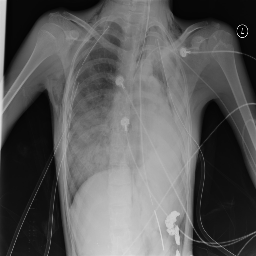

1/1 [==============================] - 1s 938ms/step
Classification/Prediction:  Pnemonia Detected
Detection/Prediction: 
1/1 [==============================] - 0s 24ms/step


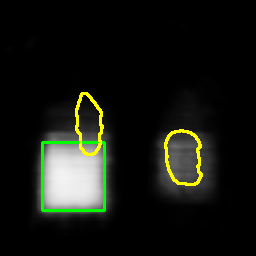

Predicted Pnemonia image with Bounding Box


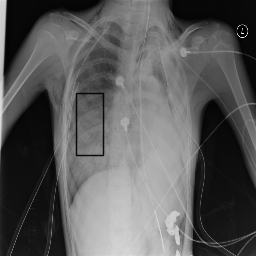

In [97]:
#New sample for prediction - once this works, integrate this to the window/explorer section (next cell)
# !pip3 install pillow-heif
# from PIL import Image
# from pillow_heif import register_heif_opener
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import save_model, load_model

# register_heif_opener()
# file_new = Image.open(images_path + '/IMG_4910.heic')
# file_new.convert("1")
# file_new = file_new.resize((256,256))
# file_new_np = np.array(file_new)
# mono = cv2.cvtColor(file_new_np, cv2.COLOR_BGR2GRAY )
# cv2_imshow(mono)

test_dir = images_path + '/stage_2_test_images/'
test_sample = rnd.choice(os.listdir(test_dir))
dicom_file = dicom.dcmread(test_dir + test_sample)
mono = cv2.resize(dicom_file.pixel_array, (256,256))
cv2_imshow(mono)

mono_rgb = np.repeat(mono[..., np.newaxis], 3, -1)
mono_rgb = np.squeeze(mono_rgb)

mono_rgb_vgg16 = preprocess_input(mono_rgb) 
pickled_model_resnet = load_model(images_path + 'model_TL_Resnet50.h5')

y_pred_mono = pickled_model_resnet.predict(np.array([mono_rgb_vgg16]))
y_pred_final=[]
for i in y_pred_mono:
  y_pred_final.append(np.argmax(i))
out_label = ['Pnemonia Detected', 'No Pnemonia', 'No Pnemonia/Enlarged Lungs']
print("Classification/Prediction: ", out_label[y_pred_final[0]])
if y_pred_final[0] == 0:
  print("Detection/Prediction: ")
  pred_sample = np.squeeze(model_unet.predict(x=np.array([mono_rgb])))

  gray = np.expand_dims(pred_sample*255, axis=-1)
  gray = np.repeat(gray[..., np.newaxis], 3, -1)
  gray = np.squeeze(gray)
  gray = np.array(gray, np.uint8)
  # gray = np.expand_dims(pred_mask*255, axis=-1)
  gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
  # apply thresholding on the gray image to create a binary image
  ret,thresh = cv2.threshold(gray,127,255,0)
  # find the contours
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  # take the first contour
  if len(contours) >0:
    cnt = contours[0]
    # compute the bounding rectangle of the contour
    x,y,w,h = cv2.boundingRect(cnt)
    pred_sample_bb = pred_sample*255
    pred_sample_bb = np.repeat(pred_sample_bb[..., np.newaxis], 3, -1)
    pred_sample_bb = np.squeeze(pred_sample_bb)
    pred_sample_bb_copy = pred_sample_bb.copy() # create copy of the base image
    # draw contour
    pred_mask_bb_copy = cv2.drawContours(pred_mask_bb_copy,[cnt],0,(0,255,255),2)
    # draw the bounding rectangle
    # pred_mask_bb_copy = cv2.rectangle(pred_mask_bb_copy,(x,y),(x+w,y+h),(0,255,0),2)
    cv2_imshow(pred_mask_bb_copy)
    v1, v2, v3, v4 = x,y,w,h

    org_img_copy = mono.copy()
    cv2.rectangle(org_img_copy, (v1, v2), (v1+v3, v2+v4), (0, 255, 0), 1, cv2.LINE_AA)
    print("Predicted Pnemonia image with Bounding Box")
    cv2_imshow(org_img_copy)
  else:
    print("No Contour, No Bounding Box")
    cv2_imshow(pred_sample*255)
else:
  print("No Detection/Prediction")

In [99]:
from tkinter import *
# import filedialog module
from tkinter import filedialog
# !pip3 install pillow-heif
# from PIL import Image
# from pillow_heif import register_heif_opener
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import save_model, load_model

filename = ""

def browseFiles():
    filename = filedialog.askopenfilename(initialdir = "/",
                                          title = "Select a File",
                                          filetypes = (("Text files",
                                                        "*.txt*"),
                                                       ("all files",
                                                        "*.*")))
      
    # Change label contents
    label_file_explorer.configure(text="File Opened: "+filename)

def ClassifyDetectFile():
    dicom_file = dicom.dcmread(test_dir + test_sample)
    mono = cv2.resize(dicom_file.pixel_array, (256,256))
    cv2_imshow(mono)

    mono_rgb = np.repeat(mono[..., np.newaxis], 3, -1)
    mono_rgb = np.squeeze(mono_rgb)

    mono_rgb_vgg16 = preprocess_input(mono_rgb) 
    pickled_model_resnet = load_model(images_path + 'model_TL_Resnet50.h5')

    y_pred_mono = pickled_model_resnet.predict(np.array([mono_rgb_vgg16]))
    y_pred_final=[]
    for i in y_pred_mono:
      y_pred_final.append(np.argmax(i))
    out_label = ['Pnemonia Detected', 'No Pnemonia', 'No Pnemonia/Enlarged Lungs']
    print("Classification/Prediction: ", out_label[y_pred_final[0]])
    if y_pred_final[0] == 0:
      print("Detection/Prediction: ")
      pred_sample = np.squeeze(model_unet.predict(x=np.array([mono_rgb])))

      gray = np.expand_dims(pred_sample*255, axis=-1)
      gray = np.repeat(gray[..., np.newaxis], 3, -1)
      gray = np.squeeze(gray)
      gray = np.array(gray, np.uint8)
      # gray = np.expand_dims(pred_mask*255, axis=-1)
      gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
      # apply thresholding on the gray image to create a binary image
      ret,thresh = cv2.threshold(gray,127,255,0)
      # find the contours
      contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      # take the first contour
      if len(contours) >0:
        cnt = contours[0]
        # compute the bounding rectangle of the contour
        x,y,w,h = cv2.boundingRect(cnt)
        pred_sample_bb = pred_sample*255
        pred_sample_bb = np.repeat(pred_sample_bb[..., np.newaxis], 3, -1)
        pred_sample_bb = np.squeeze(pred_sample_bb)
        pred_sample_bb_copy = pred_sample_bb.copy() # create copy of the base image
        # draw contour
        pred_mask_bb_copy = cv2.drawContours(pred_mask_bb_copy,[cnt],0,(0,255,255),2)
        # draw the bounding rectangle
        # pred_mask_bb_copy = cv2.rectangle(pred_mask_bb_copy,(x,y),(x+w,y+h),(0,255,0),2)
        cv2_imshow(pred_mask_bb_copy)
        v1, v2, v3, v4 = x,y,w,h

        org_img_copy = mono.copy()
        cv2.rectangle(org_img_copy, (v1, v2), (v1+v3, v2+v4), (0, 255, 0), 1, cv2.LINE_AA)
        print("Predicted Pnemonia image with Bounding Box")
        cv2_imshow(org_img_copy)
      else:
        print("No Contour, No Bounding Box")
        cv2_imshow(pred_sample*255)
    else:
      print("No Detection/Prediction")
    
# Create the root window
window = Tk()
  
# Set window title
window.title('Image Explorer')
  
# Set window size
window.geometry("800x800")
  
#Set window background color
window.config(background = "white")
  
# Create a File Explorer label
label_file_explorer = Label(window,
                            text = "Medical Image - Explorer",
                            width = 100, height = 4,
                            fg = "blue")
  
      
button_explore = Button(window,
                        text = "Browse Files",
                        command = browseFiles)
button_classifydetect = Button(window,
                              text = "Classify & Detect Pnemonia",
                              command = ClassifyDetectFile)
button_exit = Button(window,
                     text = "Exit",
                     command = exit)
  
# Grid method is chosen for placing
# the widgets at respective positions
# in a table like structure by
# specifying rows and columns
label_file_explorer.grid(column = 1, row = 1)
  
button_explore.grid(column = 1, row = 2)
  
button_exit.grid(column = 1,row = 3)
  
# Let the window wait for any events
window.mainloop()

#This cell does not work on Collab (shows below error for window/display variable)
#cell able to work on jupyter notebook, but integration to model/file path incomplete.

TclError: ignored